# 문제 설명
- 로그데이터 분석 및 매출 증가를 위한 액션아이템 도출

- 컬럼 설명

| Property	| Description |
| --- | --- |
| event_time | Time when event happened at (in UTC).|
|event_type	| view / cart / purchase. |
|product_id	|ID of a product|
|category_id|	Product's category ID|
|category_code|	Product's category code name|
|brand|	Downcased string of brand name. <br/> Can be missed.|
|price|	Float price of a product. Present.|
|user_id|	Permanent user ID.|
|user_session|	Temporary user's session ID. <br/> Same for each user's session. <br/> Is changed every time </br> user come back to online store <br/> from a long pause.|
 

## 라이브러리 준비

In [1]:
# 주피터환경에서 코드접기를 위한 라이브러리 설치 
# !pip install jupyter_nbextensions_configurator
# !jupyter nbextensions_configurator enable --user
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user

# 참고:https://gmnam.tistory.com/224

In [2]:
# plotly 관련 설치
# !pip install plotly
# !pip install chart_studio
# !pip install cufflinks

# parquet 저장 및 로드 라이브러리 설치
# !pip install pyarrow
# !pip install fastparquet
# !python -m pip install --upgrade pip

# 변수명->문자출력
# !pip install varname

In [3]:
# 라이브러리 모음
#데이터셋 처리
import pandas as pd 
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from copy import deepcopy
from collections import defaultdict

#변수명 문자형태로 출력
from varname import nameof
import inspect, re

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

# 오프라인에서 plotly 그래프 띄우기
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()
# import plotly standard
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
# Cufflinks wrapper on plotly
import cufflinks as cf
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
# plotly + cufflinks in offline mode
from plotly.offline import iplot
cf.go_offline()
# set the global theme
cf.set_config_file(world_readable=True, theme='pearl', offline=True)

#시간 데이터 처리
from datetime import datetime, timedelta, timezone
import datetime as dt
import time
from dateutil import tz

import warnings
warnings.simplefilter("ignore" )

In [4]:
# 그래프 한글폰트 출력을 위한 코드
def get_font_family():
    '''
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    '''
    import platform
    system_name = platform.system()
    # mac OS 일때
    if system_name == 'Darwin' :
        font_faimly = 'AppleGothic'
    # 윈도우일떄 
    elif system_name == 'Windows':
        font_family = 'Malgun Gothic'
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = 'NanumBarunGothic'

    return font_family

# style 설정은 꼭 폰트설정 위에서 한다. 
# style에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 깨진다.
# plt.style.use('seaborn')

#폰트설정
plt.rc('font', family=get_font_family())

#마이너스폰트 설정
plt.rc('axes', unicode_minus=False)

# 그래프에 retina display 적용
# 그래프 해상도 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

---

# 전처리

## 데이터 포맷 변경 (CSV -> Parquet)
- 파일의 용량이 각각 5GB 내외로 매우 크다
    - RAM에 무리
    - 분석시 소요시간 증가
- 용량 축소를 위하여 CSV형태의 파일을 Parquet 형태로 변환하여 용량을 줄인다.
- **최초 1회 실행** (local환경 소요시간 약 20분)

In [5]:
# 데이터 포맷 변경

# import os

# PATH_INPUT = './input/'

# def csv_to_parquet(lst):
#     '''csv파일을 parquet형태로 변환하여 저장하는 함수'''
    
#     for file in lst:
#         csv_file = PATH_INPUT + f'{file}.csv'
#         parquet_file = PATH_INPUT + f'{file}_transformed.parquet'
        
#         chunksize = 1000000
#         csv_stream = pd.read_csv(csv_file, sep=',', chunksize=chunksize, low_memory=False)

#         print('현재파일', file)
#         for i, chunk in enumerate(csv_stream, start=1):
#             print("Chunk", i)
#             if i == 1:
#                 # 스키마 설정(csv형태 그대로)
#                 parquet_schema = pa.Table.from_pandas(df=chunk).schema
#                 # Open a Parquet file for writing
#                 parquet_writer = pq.ParquetWriter(parquet_file, parquet_schema, compression='ZSTD')
#             # Write CSV chunk to the parquet file
#             table = pa.Table.from_pandas(chunk, schema=parquet_schema)
#             parquet_writer.write_table(table)
        
#         # 매 파일 종료 시, 파일 변환 전/후 용량 출력
#         csv_size = os.path.getsize(csv_file)
#         parquet_size = os.path.getsize(parquet_file)
#         print(file,"변환 전 : {:.2f} MB".format(csv_size / (1024 ** 2)))
#         print(file,"변환 후 : {:.2f} MB".format(parquet_size / (1024 ** 2)))
#         print('\n')
#     else :
#         parquet_writer.close()

# # 2019년 10월부터 2020년 4월까지의 데이터 변환
# file_list = ['2019-Oct','2019-Nov','2019-Dec', '2020-Jan','2020-Feb','2020-Mar','2020-Apr']
# csv_to_parquet(file_list)        

---

## 결측치 처리 및 자료형 변환
1. 컬럼 제거 
    - `category_id` : 불필요. category_code로 대체
2. 결측치 처리
    - `user_session` : user_id, event_time 기준으로 정렬 후, forward fill 방식으로 해결
    - `category_code`, `brand` : 'unknown'문자열로 대체, 분석에 사용
3. 자료형 변환
    - datetime : `event_time`
    - category : `evnet_type`, `category_code`  (용량축소, object->category)
    - float32 : `price` (용량축소, float64->float32)
    - int32 : `user_id` (용량축소, int64->int32)

In [6]:
# 결측치 처리 및 자료형 변환 함수 생성
# def feature_engineering(df):
#     # 1. category_id 제거
#     df = df.drop('category_id', axis=1)
    
#     # 1. 결측 치 처리
#     # 1-1. user_session -> user_id, event_time 순으로 정렬 후 ffill 방식 사용
#     df['user_session'] = df.sort_values(['user_id','event_time'])['user_session'].fillna(method='ffill')

#     # 1-2. category_code, brand -> unknown 정보없음 으로 대체 
#     df = df.fillna('unknown')
    
#     # 2. dtypes 변경
#     # category 변환
#     df[['event_type','category_code']] = df[['event_type','category_code']].astype('category')
    
#     # int 변환
#     df[['user_id', 'product_id']] = df[['user_id', 'product_id']].astype('int32')
    
#     # float 변환
#     df['price'] = df['price'].astype('float32')
    
#     # datetime 변환
#     df['event_time'] = pd.to_datetime(df['event_time'], format = '%Y-%m-%d %H:%M:%S UTC')    
    
#     return df

- parquet 파일 로드 -> 전처리 -> parquet 저장
- 이후부터는 parquet 로딩 후 바로 분석 진행
- **최초 1회 실행**

In [7]:
# 실시코드

# file_list = ['2019-Oct','2019-Nov', '2019-Dec', '2020-Jan','2020-Feb','2020-Mar','2020-Apr']
# PATH_INPUT = './input/'

# # 중복값 제거 기준
# cols = ['event_time','event_type','product_id','user_id']
# for fname in file_list:
#     print(fname)
    
#     # parquet 불러오기
#     PATH = PATH_INPUT + f'{fname}_transformed.parquet'
#     df_loaded = pd.read_parquet(PATH, engine='pyarrow')
#     print(fname, '불러오기 완료')
#     time.sleep(5)
    
#     # 결측치 및 자료형 변경
#     df_engineered = feature_engineering(df_loaded)
#     print(fname,'결측치 및 자료형 변경 완료')
#     time.sleep(5)

    
#     # 전처리 결과 내보내기
#     F_PATH_output = PATH_INPUT + f'{fname}_engineered.parquet'
#     df_engineered.to_parquet(F_PATH_output, engine='pyarrow', index=False, compression='ZSTD')
#     time.sleep(5)   
    
#     print('전처리 및 결과물 내보내기 완료', end='\n')                   

## 중복값 확인 및 제거
- `event_time`,`event_type`,`product_id`,`user_id` 4가지의 컬럼을 이용하여 중복값 확인
    - 모든 column 사용시 dead kernel 발생

- event_time컬럼은 초 단위로 기록되어 있다.
- **한 유저가 같은 시간(초단위)에 동일한 이벤트를 여러개 생성한다는 것을 비정상으로 추정하고 제거한다.**

In [8]:
# 중복값 제거 및 내보내기
# # 데이터셋 파일명
# file_list = ['2019-Oct','2019-Nov', '2019-Dec', '2020-Jan','2020-Feb','2020-Mar','2020-Apr']

# # 데이터셋 변수명 
# df_lst = ['df_19_oct', 'df_19_nov', 'df_19_dec', 'df_20_jan', 'df_20_feb', 'df_20_mar', 'df_20_apr']

# # 중복검사 대상
# cols = ['event_time','event_type','product_id','user_id']

# PATH_INPUT = './input/'

# for fname, df in zip(file_list, df_lst):
#     PATH = PATH_INPUT + f'{fname}_engineered.parquet'
    
#     # file명 이용하여 변수명 지정
#     tmp = 'df_'+fname[2:].lower().replace('-','_') 
#     locals()[tmp] = pd.read_parquet(PATH, engine='pyarrow')
#     print(fname, '불러오기 완료')
    
#     # 중복값 제거
#     print('중복값 제거 전 shape :', locals()[df].shape)
#     locals()[df] = locals()[df].drop_duplicates(subset=cols, keep='first')
#     print('중복값 제거 후 shape :', locals()[df].shape)    
    
#     # 전처리 결과 내보내기
#     F_PATH_output = PATH_INPUT + f'{fname}_engineered(drop_dup).parquet'
#     locals()[df].to_parquet(F_PATH_output, engine='pyarrow', index=False, compression='ZSTD')
    
    
#     # 메모리 제거
#     del locals()[df]
#     print(df, '메모리제거 완료')
#     print('=='*10)
#     time.sleep(5)

---

# EDA

## Load Dataset

In [9]:
# file_list = ['2019-Oct','2019-Nov', '2019-Dec', '2020-Jan','2020-Feb','2020-Mar','2020-Apr']
file_list = ['2019-Oct','2019-Nov']

PATH_INPUT = './input/'

for fname in file_list:
    PATH = PATH_INPUT + f'{fname}_engineered(drop_dup).parquet'
    
    # file명 이용하여 변수명 지정
    tmp = 'df_'+fname[2:].lower().replace('-','_') 
    locals()[tmp] = pd.read_parquet(PATH, engine='pyarrow')
    
    
    print(fname, locals()[tmp].shape)
    print('=='*10)
    
    time.sleep(5)

2019-Oct (42413557, 8)
2019-Nov (67392950, 8)


## 컬럼 자료형 확인
- `event_time` : 로그 발생시간
- `event_time` : 로그 종류 3가지 (view/cart/purchase), category
- `category_id` : 카테고리 id, int
- `category_code` : 카테고리 code, object
- `brand` : 제품 브랜드, object
- `price` : 제품 가격, float
- `user_id` : 유저 id, int
- `user_session` : 유저 세션, object

In [10]:
# 메모리 1.5GB+ -> batch처리 가능한지 추후 학습 및 적용
df_19_oct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42413557 entries, 0 to 42413556
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   event_type     category      
 2   product_id     int32         
 3   category_code  category      
 4   brand          object        
 5   price          float32       
 6   user_id        int32         
 7   user_session   object        
dtypes: category(2), datetime64[ns](1), float32(1), int32(2), object(2)
memory usage: 1.5+ GB


---

---

## 단일컬럼 확인

### `event_time`
- 일자별로 샘플링 후(10%) 시각화 진행 
    - 경향성만 보면 되는데, full dataset 사용시 시간이 오래 걸린다.
    - z-test를 통한 모집단에서의 일자별 비율과, 표본에서의 일자별 비율 비교
        - H0 : 두 집단간의 비율 차이 없다.
        - H1 : 두 집단간의 비율 차이 있다.
            - 모든 일자에서 p-value : 0.99 이므로 귀무가설 채택한다. 
            - **'두 집단간의 비율 차이 없다'**
            
    
        

#### 샘플링

In [11]:
# 샘플링 및 일자별 비율검정 (모비율 vs 샘플비율)
by = df_19_oct['event_time'].dt.dayofyear
df_samp = df_19_oct.groupby(by).sample(frac=0.1, random_state=27).sort_index()
print(df_samp.shape)
df_samp.head()

(4241354, 8)


event_time event_type  product_id  \
4  2019-10-01 00:00:04       view     1004237   
6  2019-10-01 00:00:08       view    17300353   
9  2019-10-01 00:00:11       view     1004545   
17 2019-10-01 00:00:18       view    10900029   
24 2019-10-01 00:00:23       view     6200260   

                        category_code   brand        price    user_id  \
4              electronics.smartphone   apple  1081.979980  535871217   
6                             unknown   creed   380.959991  555447699   
9              electronics.smartphone  huawei   566.010010  537918940   
17           appliances.kitchen.mixer   bosch    58.950001  519528062   
24  appliances.environment.air_heater   midea    47.619999  538645907   

                            user_session  
4   c6bd7419-2748-4c56-95b4-8cec9ff8b80d  
6   4fe811e9-91de-46da-90c3-bbd87ed3a65d  
9   406c46ed-90a4-4787-a43b-59a410c1a5fb  
17  901b9e3c-3f8f-4147-a442-c25d5c5ed332  
24  7d9a8784-7b6c-426e-9924-9f688812fd71

- 샘플과 모집단간 일자별 비율 검정

In [12]:
# 모집단, 표본집단 생성 - 일자별 event_count 
prop = df_19_oct['event_time'].dt.dayofyear.value_counts().sort_index()
samp = df_samp['event_time'].dt.dayofyear.value_counts().sort_index()

In [13]:
# H0 채택 '모든 날짜의 비율차이는 없다'

# H0 : 두 집단간 비율 차이가 없다.
# H1 : 두 집단간 비율 차이가 있다.

from statsmodels.stats.proportion import proportions_ztest

n_day_rows = np.array([prop.sum(), samp.sum()])

for d, p, s in zip(prop.index, prop.values, samp):
    n_day = np.array([p, s])
    z_score, p_value = proportions_ztest(count=n_day, nobs=n_day_rows, 
                                         alternative='two-sided')
    print(f'{d}일 - p_value:{p_value}')

274일 - p_value:0.9994522794021067
275일 - p_value:0.9989987865753647
276일 - p_value:0.9991848113879719
277일 - p_value:0.9994720211473208
278일 - p_value:0.9996889329637718
279일 - p_value:0.9998875816122142
280일 - p_value:0.999224463683306
281일 - p_value:0.9990495047139
282일 - p_value:0.9996923705724862
283일 - p_value:0.9996734225503048
284일 - p_value:0.999679638666599
285일 - p_value:0.9993139657331673
286일 - p_value:0.9995507761471824
287일 - p_value:0.9997121517435846
288일 - p_value:0.9995295898918608
289일 - p_value:0.999481560742917
290일 - p_value:0.9999099185659129
291일 - p_value:0.9991130698250281
292일 - p_value:0.9998819429475211
293일 - p_value:0.9999211265212942
294일 - p_value:0.9997032006157069
295일 - p_value:0.9990606729327917
296일 - p_value:0.9998848484802979
297일 - p_value:0.9992598796873173
298일 - p_value:0.9999130536972984
299일 - p_value:0.999270752527656
300일 - p_value:0.9998845275339768
301일 - p_value:0.9996725450454778
302일 - p_value:0.9994471611963647
303일 - p_value:0.9996

#### 시각화 - 특성공학 전

- 주차별 (월~일)
    - 40주차 : 화-일 (6일)
    - 41~43주차 : 정상 (7일)
    - 44주차 : 월-목 (4일)
- **44주차의 금,토,일(11월1일~3일) 데이터를 11월 데이터로부터 추출하여 concat 필요**

- 일별 (1~31일)
    - 월초,월말이 중순에 비해 event수가 상대적으로 적다.
    - event_type과 복합 분석 필요
<br><br/>  
- 요일별
    - 월요일 : 10월초 생략
    - 금~일요일 : 10월말 생략
    - **'주차-요일별' 혹은 event_type과 복합하여 분석필요**
<br><br/>  
- 시간별
    - 새벽 2시부터 event수가 증가하기 시작해서 16시에 가장 많은 event수를 보인다. -> 이상하다
    - 데이터셋의 timezone이 'UTC 0'으로 설정되어 있다. 
    - **카자흐스탄(동부, 알마티) 국가의 이커머스 데이터셋으로 가정하였으므로 시간대 UTC+6으로 시간 변경**

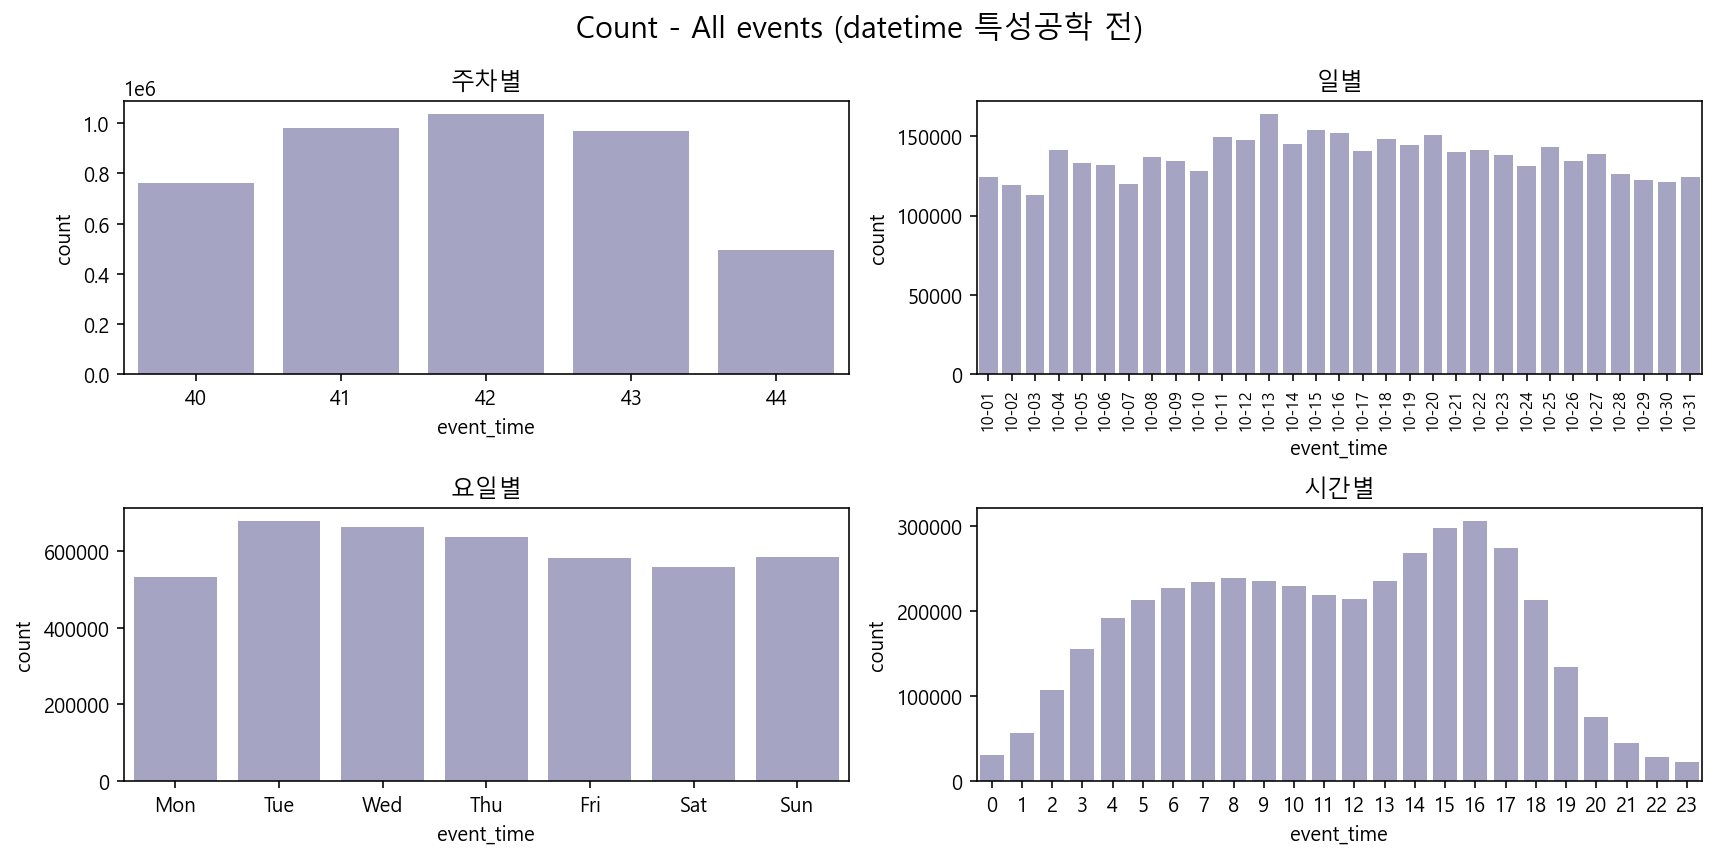

In [14]:
# 시각화 code

fig, ax = plt.subplots(2,2, figsize=(12,6))

# 주
x = df_samp['event_time'].dt.week
sns.countplot(x = x, color='#A0A0C8', ax=ax[0,0])
ax[0,0].set_title('주차별')

# 일
x = df_samp['event_time'].dt.strftime('%m-%d')
g = sns.countplot(x = x, color='#A0A0C8', ax=ax[0,1])
g.set_xticklabels(g.get_xticklabels(),fontsize=8, rotation=90)
ax[0,1].set_title('일별')

# 요일
x = df_samp['event_time'].dt.dayofweek
dow_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.countplot(x = x, color='#A0A0C8', ax=ax[1,0])
ax[1,0].set_title('요일별')
ax[1,0].set_xticklabels(dow_label)

# 시간
x = df_samp['event_time'].dt.hour
sns.countplot(x= x, color='#A0A0C8', ax=ax[1,1])
ax[1,1].set_title('시간별')

fig.suptitle('Count - All events (datetime 특성공학 전)', fontsize=15)
fig.tight_layout()
plt.show()

- timezone 변경 (UTC 0 -> UTC+6)

In [15]:
# time zone 변경
# df_lst = ['df_19_oct', 'df_19_nov', 'df_19_dec', 
#           'df_20_jan', 'df_20_feb', 'df_20_mar', 'df_20_apr']
df_lst = ['df_19_oct','df_19_nov']

for df in df_lst:
    print(df)
    locals()[df]['event_time'] = locals()[df]['event_time'].dt.tz_localize(tz.UTC)        # UTC localize
    print('변경 전:',locals()[df]['event_time'][0] )
    locals()[df]['event_time'] = locals()[df]['event_time'].dt.tz_convert('Asia/Almaty')  # 알마티(카자흐스탄) 시간대 적용
    print('변경 후:',locals()[df]['event_time'][0] )
    print('========'*5)

df_19_oct
변경 전: 2019-10-01 00:00:00+00:00
변경 후: 2019-10-01 06:00:00+06:00
df_19_nov
변경 전: 2019-11-01 00:00:00+00:00
변경 후: 2019-11-01 06:00:00+06:00


- 11월 1~3일 데이터 추출 및 10월 마지막에 concat

In [16]:
# 11월 1~3일 데이터 추출 및 10월 데이터에 concat
condition = df_19_nov['event_time'].dt.week == 44
tmp = df_19_nov[condition]

df_19_oct = pd.concat([df_19_oct, tmp]).reset_index(drop=True)
print('df - tail')
df_19_oct.tail(2)

df - tail


event_time event_type  product_id  \
46735260 2019-11-03 23:59:59+06:00       view    22700541   
46735261 2019-11-03 23:59:59+06:00       view     1004956   

                   category_code    brand       price    user_id  \
46735260                 unknown  unknown   14.160000  567089454   
46735261  electronics.smartphone   xiaomi  382.119995  562015918   

                                  user_session  
46735260  cf668a7f-19ed-4ec5-89d1-da8b755553ff  
46735261  59cf6e10-ea4e-432e-9d16-37b2c6a6d8d4

- 11월 데이터 병합 후 자료형 확인 
    - `category_code`,`brand` : 10월 데이터에는 없던 새로운 개체가 생성되면서 category가 object로 변환됐다.
        - 다시 category로 변경

In [17]:
df_19_oct.dtypes

event_time       datetime64[ns, Asia/Almaty]
event_type                          category
product_id                             int32
category_code                         object
brand                                 object
price                                float32
user_id                                int32
user_session                          object
dtype: object

In [18]:
def convert_dtype(df):
    df[['category_code','brand']] = df[['category_code','brand']].astype('category')
    return df

df_19_oct = convert_dtype(df_19_oct)

In [19]:
df_19_oct.dtypes

event_time       datetime64[ns, Asia/Almaty]
event_type                          category
product_id                             int32
category_code                       category
brand                               category
price                                float32
user_id                                int32
user_session                          object
dtype: object

#### 시각화 - 특성공학 후 - 1

- 주차별 (월~일)
    - 11월 1~3일 데이터 추출 및 concat 완료
<br><br/>        
- 일별 (10월1일~11월3일)
    - timezone 변경으로, 10월 1일 일부데이터 (00시~5시59분59초)누락     
    - **event_type과 복합 분석 필요**
<br><br/>  
- 요일별
    - 월요일 : 9월30일(월) 누락
    - **'주차-요일별' 혹은 event_type과 복합하여 분석필요**
<br><br/>  
- 시간별
    - 카자흐스탄(동부, 알마티) timezone으로 변경 완료 (UTC+6)
    - 10월 1일 0~5시 59분 59초 데이터 누락

In [20]:
# 재 샘플링
by = df_19_oct['event_time'].dt.dayofyear
df_samp = df_19_oct.groupby(by).sample(frac=0.1, random_state=27).sort_index()
print(df_samp.shape)
df_samp.tail()

(4673528, 8)


event_time event_type  product_id  \
46735238 2019-11-03 23:59:59+06:00       view    26401457   
46735246 2019-11-03 23:59:59+06:00       view     1201391   
46735247 2019-11-03 23:59:59+06:00       view     1004767   
46735248 2019-11-03 23:59:59+06:00       view    28721240   
46735258 2019-11-03 23:59:59+06:00       view    28716595   

                   category_code    brand        price    user_id  \
46735238                 unknown  lucente   114.550003  517323198   
46735246      electronics.tablet    apple  1518.439941  513763965   
46735247  electronics.smartphone  samsung   241.860001  545052249   
46735248           apparel.shoes  unknown    86.230003  557442625   
46735258           apparel.shoes    baden    53.799999  515166728   

                                  user_session  
46735238  23e70f5f-9038-4d93-a2db-42a122902eb2  
46735246  a89b1a45-ab99-41b5-bc62-6adb7d2b7994  
46735247  baf5e123-6f21-4e39-a9dc-f65001f8a556  
46735248  829edaab-a9a0-4c5c-a237-b0ab960401cf  
46735258  3ed362b8-478e-4b1a-9d07-4bb078baca29

- 연한색상 : 불완전 데이터(일부 데이터 누락)

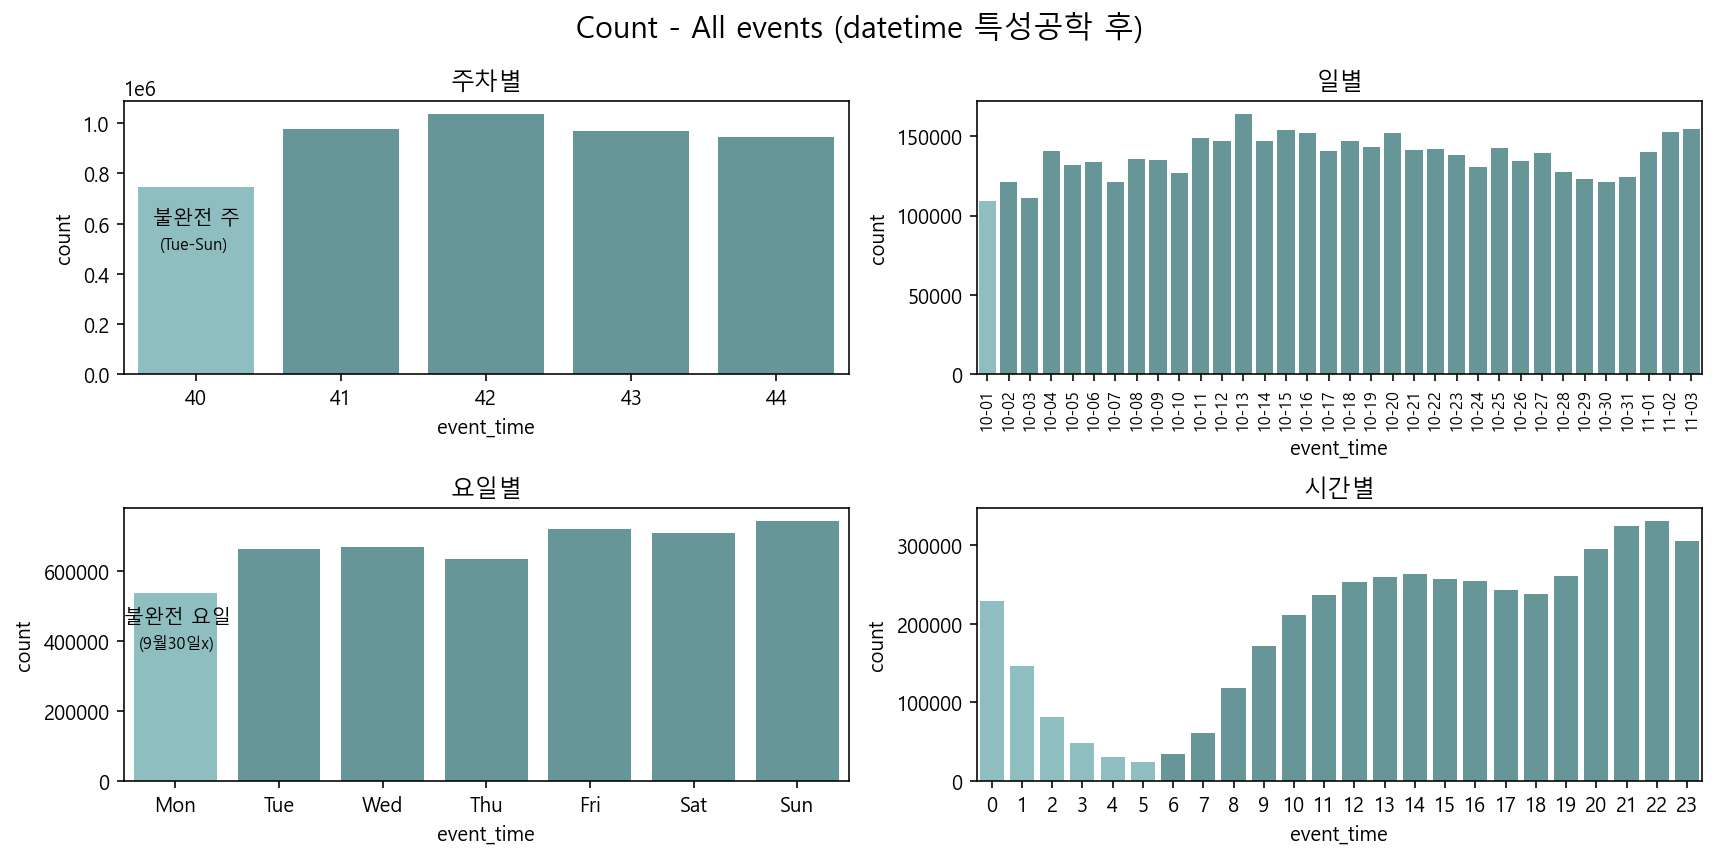

In [21]:
# 시각화
fig, ax = plt.subplots(2,2, figsize=(12,6))

# 주
x = df_samp['event_time'].dt.week
len_x = x.nunique()
pal = ['#87C6C8'] +  ['#5F9EA0'] * (len_x - 1)
g = sns.countplot(x = x, palette=pal, ax=ax[0,0])
g.set_title('주차별')
g.text(-0.3,0.6e6,'불완전 주')
g.text(-0.25,0.5e6,'(Tue-Sun)', fontsize=8)

# 일
x = df_samp['event_time'].dt.strftime('%m-%d')
len_x = x.nunique()
pal = ['#87C6C8'] +  ['#5F9EA0'] * (len_x - 1)
g = sns.countplot(x = x, palette=pal, ax=ax[0,1])
g.set_title('일별')
g.set_xticklabels(g.get_xticklabels(),fontsize=8, rotation=90)

# 요일
x = df_samp['event_time'].dt.dayofweek
len_x = x.nunique()
pal = ['#87C6C8'] +  ['#5F9EA0'] * (len_x - 1)
g = sns.countplot(x = x, palette=pal, ax=ax[1,0])
g.set_title('요일별')
g.text(-0.5, 4.5e5, '불완전 요일')
g.text(-0.35, 3.8e5, '(9월30일x)', fontsize=8)
dow_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
g.set_xticklabels(dow_label)

# 시간
x = df_samp['event_time'].dt.hour
len_x = x.nunique()
pal = (['#87C6C8'] * 6) +  (['#5F9EA0'] * (len_x - 6))
g = sns.countplot(x = x, palette=pal, ax=ax[1,1])
g.set_title('시간별')

fig.suptitle('Count - All events (datetime 특성공학 후)', fontsize=15)
fig.tight_layout()
plt.show()

- event_time 분석시에는 40주차 데이터를 통으로 날리고 사용
- 다른 분석에는 기존 데이터 계속 사용

In [22]:
# 40주차 제거
df_wo_w40 = df_19_oct[df_19_oct['event_time'].dt.week > 40]

# 샘플링
by = df_wo_w40['event_time'].dt.dayofyear
df_samp = df_19_oct.groupby(by).sample(frac=0.1, random_state=27).sort_index()
print(df_samp.shape)
df_samp.tail()

(3926696, 8)


event_time event_type  product_id  \
46735232 2019-11-03 23:59:59+06:00       view     5100767   
46735238 2019-11-03 23:59:59+06:00       view    26401457   
46735240 2019-11-03 23:59:59+06:00       view     1004870   
46735244 2019-11-03 23:59:59+06:00       view     5000500   
46735257 2019-11-03 23:59:59+06:00       view     1004718   

                      category_code    brand       price    user_id  \
46735232                    unknown  samsung   30.610001  516622972   
46735238                    unknown  lucente  114.550003  517323198   
46735240     electronics.smartphone  samsung  271.399994  516774255   
46735244  appliances.sewing_machine   janome  135.960007  513902482   
46735257     electronics.smartphone    haier   77.199997  561765733   

                                  user_session  
46735232  4d1ca9d9-2113-4b15-bc02-3d3cedd9cb52  
46735238  23e70f5f-9038-4d93-a2db-42a122902eb2  
46735240  87adee96-5635-4c6d-b0cb-b8bf0c73b367  
46735244  eb1d43d0-f95f-4552-b836-e964024f1c40  
46735257  bafdd7cd-77be-42f7-8eb4-d01ec78a1703

#### 시각화 - 특성공학 후 - 2

- 주차별
    - 42주차에 event가 가장 많고, 44주차에 가장 적다.
- 일별
    - 41주차 마지막인 13일에 가장 많은 이벤트가 발생
    - 10월 말까지 점점 하락했다가 11월 1일부터 급상승
- 요일
    - 평일(월-목) vs 주말(금-일) 주말의 이벤트 수가 평일대비 높다.
- 시간
    - 오후 9~10시에 가장 높은 수를 보이며, 새벽에는 급격히 감소한다.

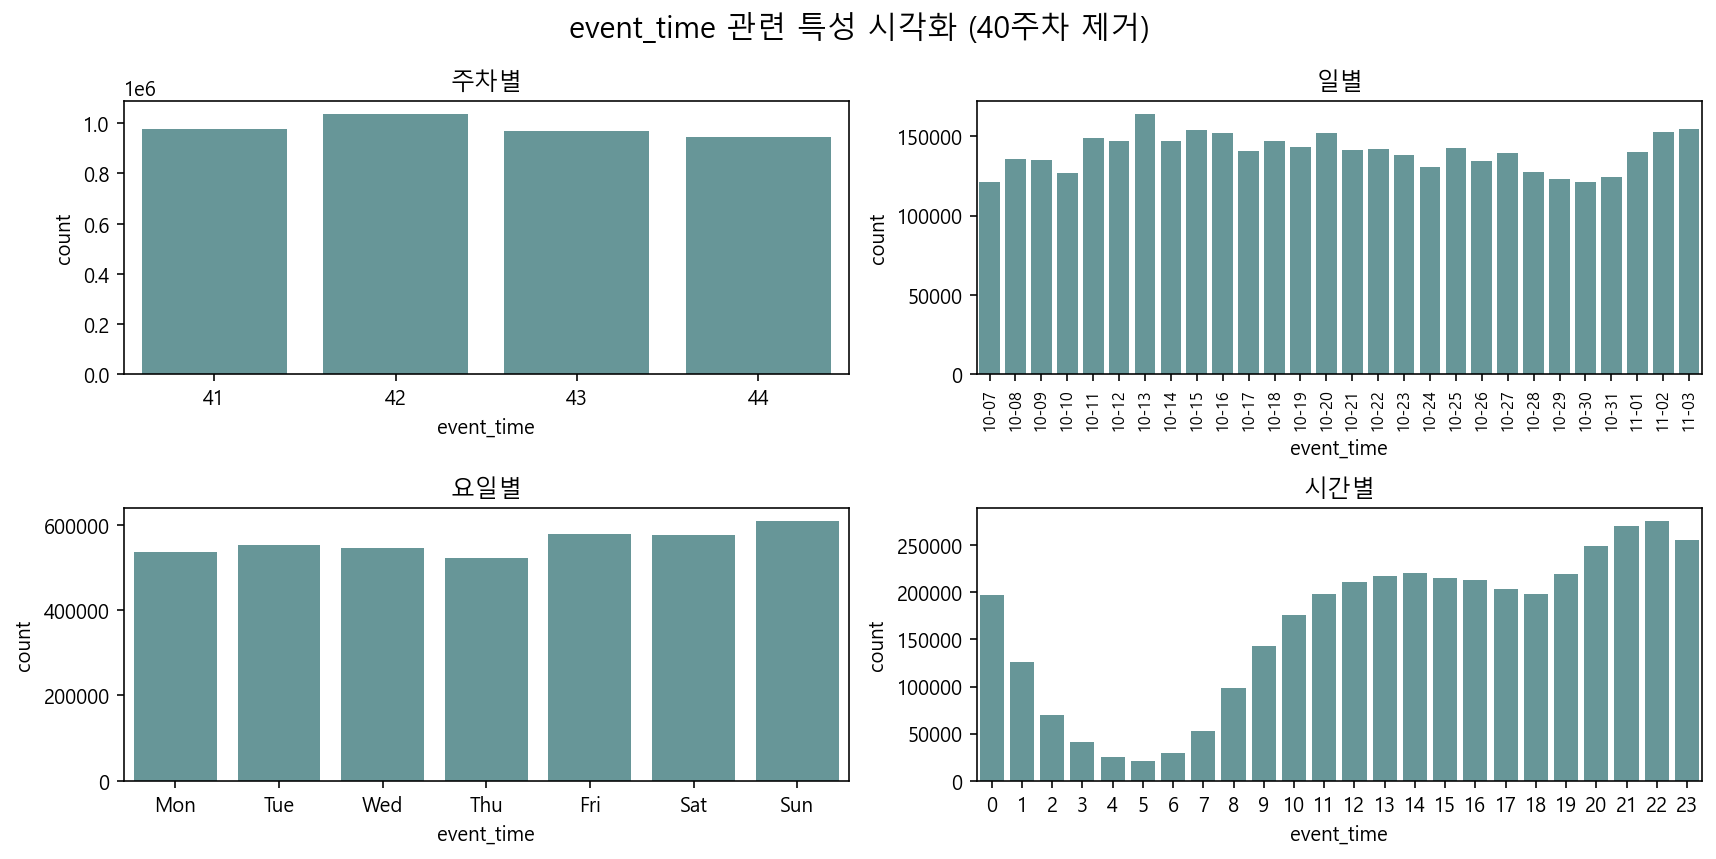

In [23]:
# 시각화
fig, ax = plt.subplots(2,2, figsize=(12,6))

color = '#5F9EA0'

# 주
x = df_samp['event_time'].dt.week
g = sns.countplot(x = x, color=color, ax=ax[0,0])
g.set_title('주차별')

# 일
x = df_samp['event_time'].dt.strftime('%m-%d')
g = sns.countplot(x = x, color=color, ax=ax[0,1])
g.set_title('일별')
g.set_xticklabels(g.get_xticklabels(),fontsize=8, rotation=90)

# 요일
x = df_samp['event_time'].dt.dayofweek
g = sns.countplot(x = x, color=color, ax=ax[1,0])
g.set_title('요일별')
dow_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
g.set_xticklabels(dow_label)

# 시간
x = df_samp['event_time'].dt.hour
g = sns.countplot(x = x, color=color, ax=ax[1,1])
g.set_title('시간별')

fig.suptitle('event_time 관련 특성 시각화 (40주차 제거)', fontsize=15)
fig.tight_layout()
plt.show()

---

### `event_type`

- view 대비 cart, purchase가 매우 낮다.
    -> 구매 전환이 낮다

In [468]:
# event_type별 event 발생 수
grouped = df_19_oct['event_type'].value_counts().reset_index() \
            .rename(columns={'event_type':'counts','index':'event_type'})
grouped

event_type    counts
0       view  44904188
1       cart    952996
2   purchase    806709

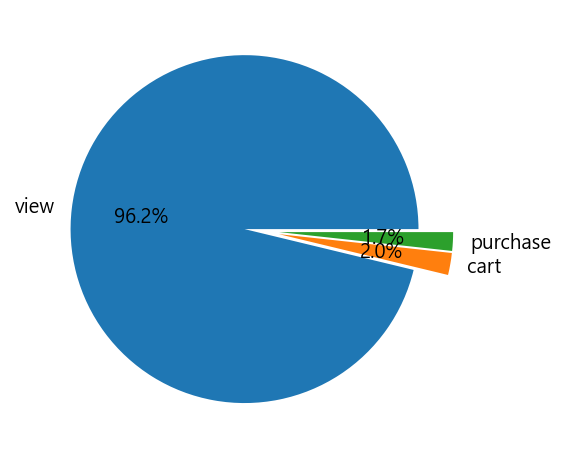

In [470]:
plt.pie(x='counts', labels='event_type', data=grouped, autopct='%.1f%%', explode=[0.1, 0.1, 0.1])
plt.show()

- Funnel 분석
    - 고객의 유입시점부터 설정한 목표(구매, 회원가입 등)까지의 단계별 프로세스를 분석
    - 해당 과제는 `Product View -> Add to Cart -> Purchase` 3단계를 이용한다. 

- Funnel로 목표 달성하기
1. 유입을 폭발적으로 늘린다.
2. 전환율을 개선한다. 
    -> 해당과제에서는 유입은 많지만 전환율이 매우 낮으므로 전환율을 개선할 방법을 최우선으로 찾아야 한다.

![image](https://user-images.githubusercontent.com/65796882/196649052-2d33f4ba-ef0e-4e0b-ab50-cf41062b02c4.png)
(image source : https://www.webdew.com/blog/how-to-conduct-a-funnel-analysis)


In [471]:
# event_type별 event 발생 비율
grouped = round(df_19_oct['event_type'].value_counts(normalize=True)*100,2)
grouped = grouped.reset_index().rename(columns={'event_type':'prop. (%)','index':'event_type'})
fig = px.funnel(grouped, y='event_type', x='prop. (%)',
               width=500, height=300)
fig.show()

---

### `product_id`

- 제품번호 고유개수 17만개
- 카테고리로 제품 종류는 추정 가능
<br/><br/>
- 100만번대(1M) product_id 종류가 전체의 2.9% 차지하는데, event 발생횟수는 34.3% 나 차지한다.
    - 100만번대의 카테고리 코드 확인
- 이벤트 발생 상위 20개 중 2가지(4804056, 5100816)을 제외한 product_id가 100으로 시작

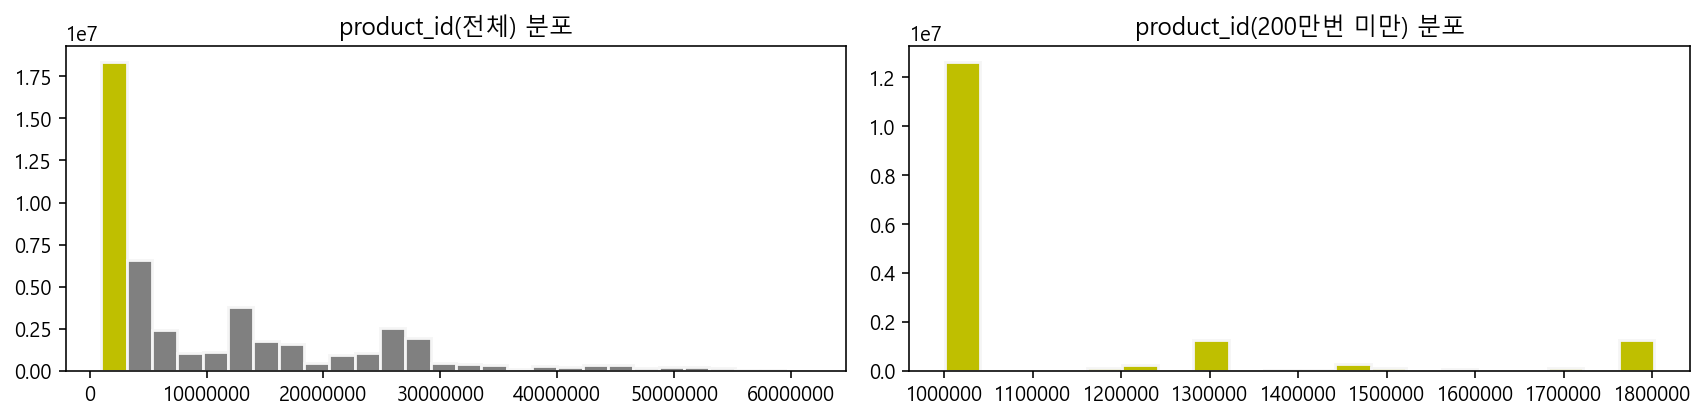

In [27]:
# 대략적인 분포 - 전체 번호
# 10M이하에 대부분의 이벤트가 몰려있다.
fig, ax = plt.subplots(1,2 , figsize=(12,3))

ax[0].hist(x=df_19_oct['product_id'], bins=28, color= 'gray',
          edgecolor = 'whitesmoke', linewidth = 1.4)
ax[0].title.set_text('product_id(전체) 분포')
ax[0].ticklabel_format(axis='x', style='plain') #x축 눈금 지수표기 해제
ax[0].patches[0].set_facecolor('y')

cond = df_19_oct['product_id'] <= 2000000
ax[1].hist(x=df_19_oct[cond]['product_id'], bins=20, color ='y',
          edgecolor = 'whitesmoke', linewidth = 1.4)
ax[1].title.set_text('product_id(200만번 미만) 분포')
ax[1].ticklabel_format(axis='x', style='plain') #x축 눈금 지수표기 해제

plt.tight_layout()
plt.show()

- 10월 발생 product_id 수
    - 100만번대의 상품번호는 전체의 0.8%를 차지

- 10월 발생 product_id 별 event 발생 수
    - 100만번대의 상품번호가 전체의 27.0%를 차지
   

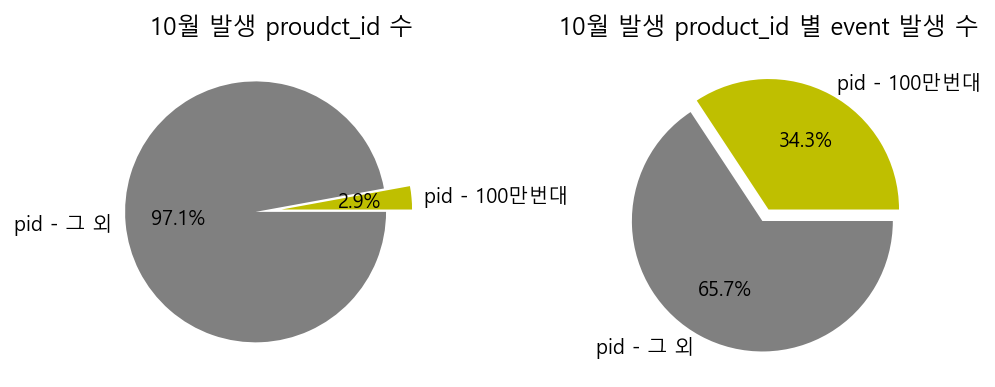

In [28]:
# pid 시각화
fig, ax = plt.subplots(1,2, figsize=(8,3))

# 100만번대 produc id 추출 조건
condition = (df_19_oct['product_id']<2000000) & (df_19_oct['product_id']>=1000000)

# 100만번대 pid 개수
n_pid_1M = df_19_oct[condition]['product_id'].nunique() 
# 그 외 pid 개수 = 전체 pid개수 - 100만번대 pid 개수
n_pid_etc = df_19_oct['product_id'].nunique() - n_pid_1M 

ax[0].pie(x=pd.Series([n_pid_1M, n_pid_etc]), 
          labels=['pid - 100만번대','pid - 그 외'], 
          autopct='%.1f%%', explode=[0,0.2], 
          colors = ['y','gray'])
ax[0].title.set_text('10월 발생 proudct_id 수')

df_19_oct['1M_yn'] = condition # 100만번대 여부 컬럼 생성
grouped = df_19_oct.value_counts('1M_yn').sort_values()

ax[1].pie(x=grouped.values, labels=['pid - 100만번대','pid - 그 외'], 
          autopct='%.1f%%', explode=[0,0.1],
          colors = ['y','gray'])
ax[1].title.set_text('10월 발생 product_id 별 event 발생 수')

# plt.tight_layout()
# plt.show()

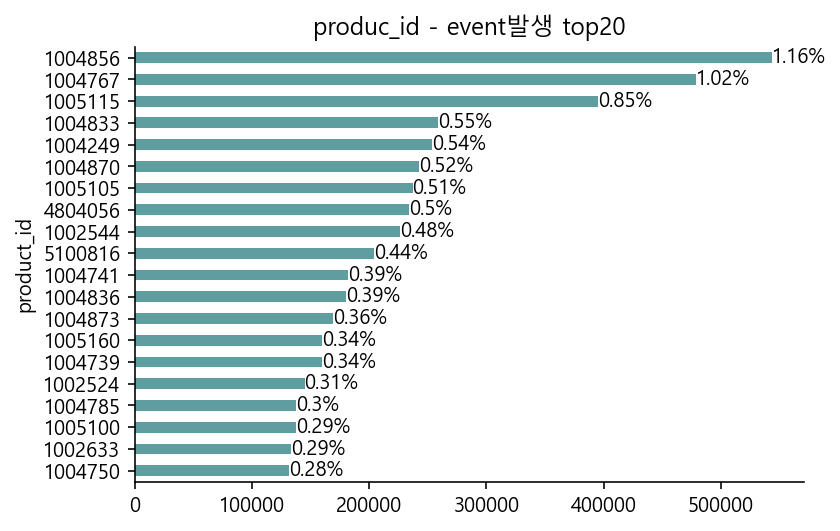

In [29]:
# event 상위 20개

grouped = df_19_oct.value_counts('product_id', sort=True).head(20).sort_values()

g =grouped.plot(kind='barh', color = '#5F9EA0')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df_19_oct)*100,2)}%', (val, bar.get_y()))

    plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('produc_id - event발생 top20')
plt.show()

- event 1개인 product id 수 -> 10957개
    - event가 1개만 있는 경울 인사이트를 얻어내기 힘들어 보인다. 
    - 하위는 의미 없어서 생략

In [30]:
tmp = df_19_oct.value_counts('product_id').reset_index().rename(columns={0:'counts'})
condition = tmp['counts']<= 1
filtered = tmp[condition]
pid_under_1 = filtered['product_id']

val = len(df_19_oct[df_19_oct['product_id'].isin(pid_under_1)])

print('product_id 길이 -> event 1개만 있는 경우 :',val, 'rows')

product_id 길이 -> event 1개만 있는 경우 : 10957 rows


---

### `category_code`

- unknown(미등록) 인 경우가 가장 많고
- 미동록을 제외하면 electronics.smartphone 이 독보적으로 높다.

In [31]:
df_19_oct.value_counts('category_code', sort=True)

category_code
unknown                         14886279
electronics.smartphone          12626373
electronics.clocks               1438553
computers.notebook               1260341
electronics.video.tv             1245311
                                  ...   
construction.tools.soldering         829
apparel.shorts                       670
auto.accessories.anti_freeze         565
apparel.jacket                       436
country_yard.furniture.bench         190
Length: 127, dtype: int64

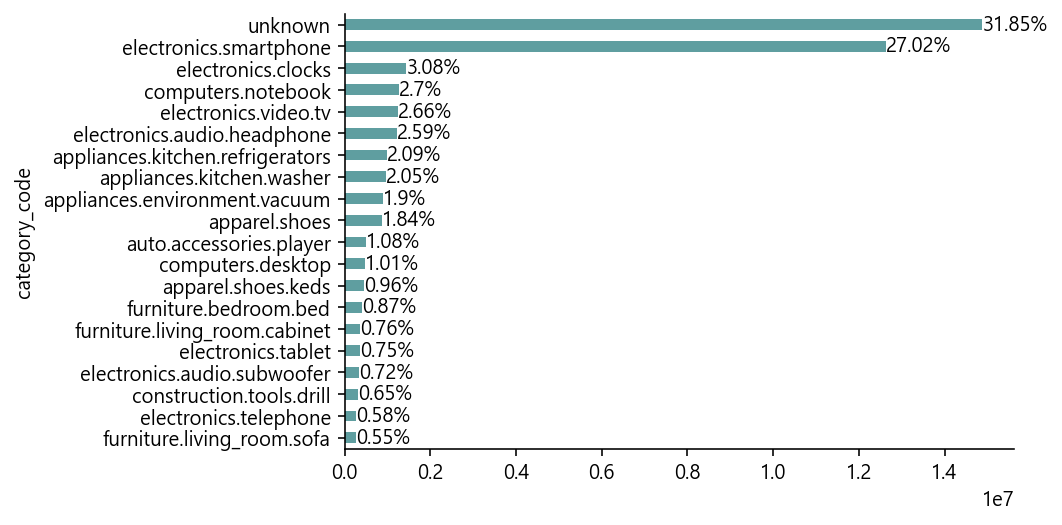

In [32]:
# 카테코리 전체 분류 기준
grouped = df_19_oct.value_counts('category_code', sort=True).nlargest(20).sort_values(ascending=True)
g = grouped.plot(kind='barh', color = '#5F9EA0')

    
for bar, val in zip(g.patches,grouped.values):
    g.annotate(f'{round(val/len(df_19_oct)*100,2)}%', (val, bar.get_y()))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

- 대분류 기준 (unknown 제외)
    - 전자기기 -> 가전제품 -> 컴퓨터 -> 의류 -> 가구 순

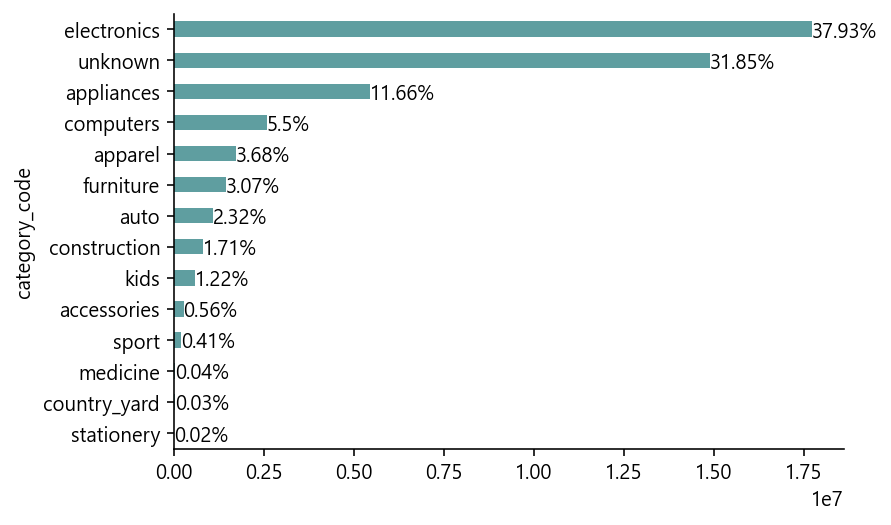

In [33]:
# 카테고리 대분류 기준
cond = df_19_oct['category_code'].apply(lambda x:x.split('.')[0]) # 대분류 필터링
grouped = df_19_oct.value_counts(cond, sort=True).nlargest(20).sort_values() 

g = grouped.plot(kind='barh', color = '#5F9EA0') 
    
for bar, val in zip(g.patches,grouped.values):
    g.annotate(f'{round(val/len(df_19_oct)*100,2)}%', (val, bar.get_y()))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

### `brand`
- 삼성 -> 애플 -> 샤오미 -> 화웨이 순
- 상위 4개가 휴대폰 제조사
- 삼성은 가전 포함
- lucente -> 카자흐스탄 악세사리 브랜드로 추정 -> category_code 전부 unknown

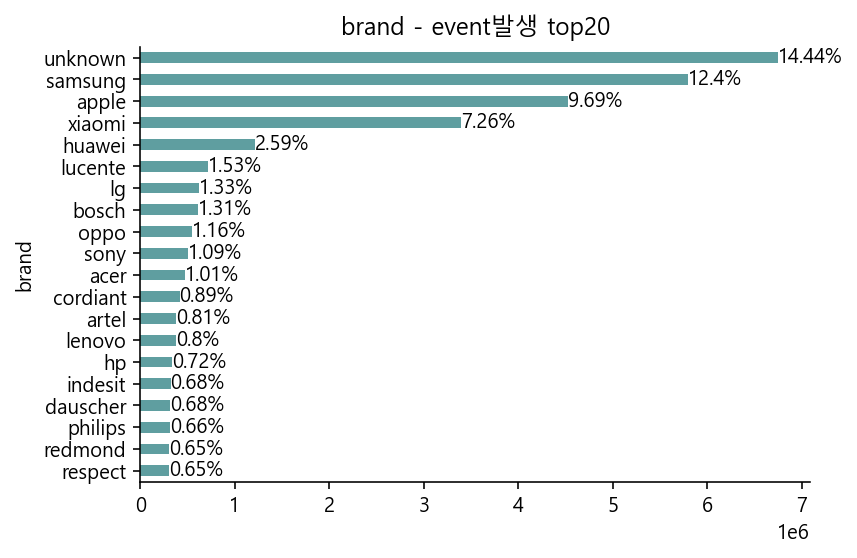

In [34]:
# event 상위 20개

grouped = df_19_oct.value_counts('brand', sort=True).head(20).sort_values()

g =grouped.plot(kind='barh', color = '#5F9EA0')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df_19_oct)*100,2)}%', (val, bar.get_y()))

    plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('brand - event발생 top20')
plt.show()

### `price`

- right-skewed
    - 가격이 왼쪽으로 치우침

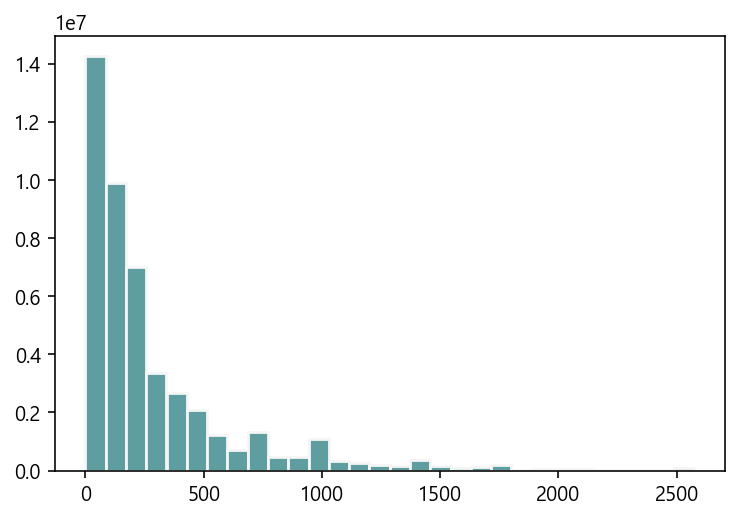

In [35]:
# 가격대
plt.hist(df_19_oct['price'], bins = 30, 
         edgecolor = 'whitesmoke', linewidth = 1.4, 
         color = '#5F9EA0')
plt.show()

- 가격이 0인 데이터 존재함

In [36]:
pd.DataFrame(df_19_oct['price'].agg(['min','max','mean','median'])).T

min          max        mean      median
price  0.0  2574.070068  238.851944  164.710007

In [37]:
df_19_oct[df_19_oct['price']==0].head()

event_time event_type  product_id  category_code    brand  \
2259 2019-10-01 08:21:36+06:00       view    53000001        unknown  unknown   
2312 2019-10-01 08:21:44+06:00       view    53000001        unknown  unknown   
2600 2019-10-01 08:22:31+06:00       view     7000684  kids.carriage  unknown   
3367 2019-10-01 08:24:38+06:00       view     4100157        unknown  unknown   
4938 2019-10-01 08:28:07+06:00       view    23301316        unknown  unknown   

      price    user_id                          user_session  1M_yn  
2259    0.0  512450748  03267357-d0e5-4831-acee-6554cba7c0b1  False  
2312    0.0  512450748  03267357-d0e5-4831-acee-6554cba7c0b1  False  
2600    0.0  555462472  c378efe2-75b4-48fa-96ec-bce2ab05d7fc  False  
3367    0.0  531057348  6b9c87ab-f991-45ce-98d2-f5ef05e0b2a4  False  
4938    0.0  521311516  f3a2fd03-13eb-4235-96bd-15329b8db1b8  False

In [38]:
# 가격이 0인 데이터의 비율
print('가격이 0인 데이터의 비율 :')
print(round(np.mean(df_19_oct['price']==0),4) * 100 ,'%')

가격이 0인 데이터의 비율 :
0.15 %


- 가격이 0인 데이터 제거

In [39]:
df_19_oct = df_19_oct.drop(df_19_oct[df_19_oct['price']==0].index, axis=0).reset_index(drop=True)

In [40]:
df_19_oct['price'].agg(['min','max','mean','median'])

min          0.770000
max       2574.070068
mean       239.217239
median     164.929993
Name: price, dtype: float64

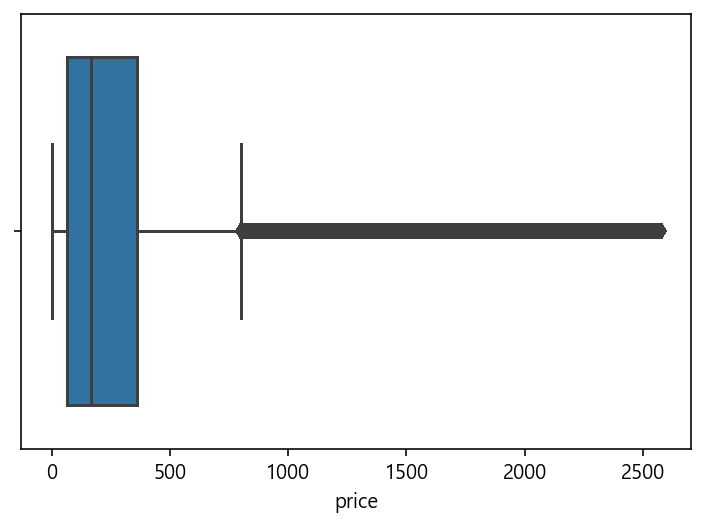

In [41]:
sns.boxplot(x='price', data=df_19_oct)
plt.show()

### `user_id`

In [42]:
pd.DataFrame(df_19_oct['user_id'].describe()).T

count          mean           std         min          25%  \
user_id  46663894.0  5.337048e+08  1.869866e+07  33869381.0  515911907.0   

                 50%          75%          max  
user_id  529780514.0  551763997.0  567211839.0

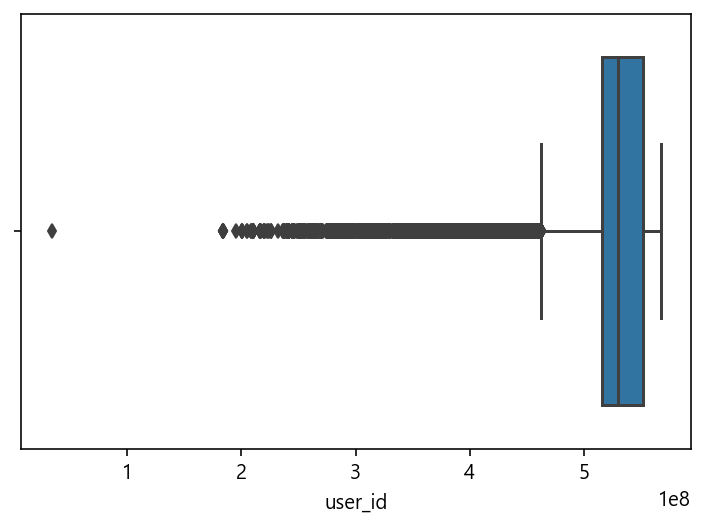

In [43]:
sns.boxplot(x='user_id', data=df_19_oct);

- 유일하게 3천만번대의 user_id를 가지는 case가 하나 있다.
    - case도 1가지밖에 없고 단순 view 데이터 이기 때문에 제거해도 무방할 것 같다.

In [44]:
df_19_oct['user_id'].sort_values()

31887245     33869381
2414989     183503497
4790610     184265397
4789633     184265397
4798355     184265397
              ...    
46663074    567211736
46663234    567211758
46663078    567211758
46663670    567211839
46663833    567211839
Name: user_id, Length: 46663894, dtype: int32

In [45]:
df_19_oct[df_19_oct['user_id']==33869381]

event_time event_type  product_id  category_code  \
31887245 2019-10-24 02:04:08+06:00       view     7002639  kids.carriage   

               brand       price   user_id  \
31887245  bumbleride  769.650024  33869381   

                                  user_session  1M_yn  
31887245  d83dc524-8a2c-4780-bbe0-f8aee03b54df  False

In [46]:
# 해당 row 제거
df_19_oct = df_19_oct.drop(31887245)

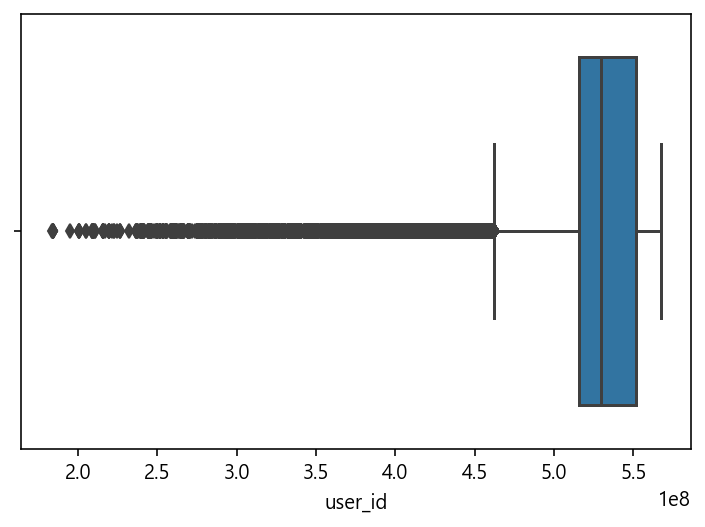

In [47]:
sns.boxplot(x='user_id', data=df_19_oct);

In [48]:
print('10월 총 방문자 수 :')
print(df_19_oct['user_id'].nunique(),'명')

10월 총 방문자 수 :
3223906 명


### `user_session`

In [49]:
print('10월 총 session 수:')
df_19_oct['user_session'].nunique()

10월 총 session 수:


10190988

In [50]:
# session별 유지시간
df_user_session = df_19_oct.groupby('user_session')['event_time'].agg(['min','max'])
df_user_session['duration'] = df_user_session['max'] - df_user_session['min']
df_user_session.sort_values('duration')

min  \
user_session                                                     
b7178847-b1da-4ceb-84c1-85b2a5b6248f 2019-10-20 15:14:06+06:00   
a396690a-026f-40b5-9fcb-ca79d1a34ed9 2019-10-27 10:03:58+06:00   
a396643c-92ab-49d6-b647-5afadd0f4138 2019-10-05 19:15:42+06:00   
a3966359-7dee-47ae-8154-c5ebb470a249 2019-10-18 13:15:00+06:00   
45c9259c-0648-4ca0-9d33-d5efdabc0b8d 2019-10-19 00:14:29+06:00   
...                                                        ...   
2e939356-e684-4cb0-8b2a-486fc204117f 2019-10-01 21:55:01+06:00   
e5f334e3-e895-4d03-a8fa-b52d7005ee93 2019-10-01 10:03:32+06:00   
906d839b-760b-4565-a985-f0290f97a818 2019-10-01 09:55:25+06:00   
18e33676-8d30-48e9-9142-d7cb1a4da86e 2019-10-01 06:51:21+06:00   
83085f41-22c3-4f27-bc29-bfaaf460d902 2019-10-01 08:25:40+06:00   

                                                           max  \
user_session                                                     
b7178847-b1da-4ceb-84c1-85b2a5b6248f 2019-10-20 15:14:06+06:00   
a396690a-026f-40b5-9fcb-ca79d1a34ed9 2019-10-27 10:03:58+06:00   
a396643c-92ab-49d6-b647-5afadd0f4138 2019-10-05 19:15:42+06:00   
a3966359-7dee-47ae-8154-c5ebb470a249 2019-10-18 13:15:00+06:00   
45c9259c-0648-4ca0-9d33-d5efdabc0b8d 2019-10-19 00:14:29+06:00   
...                                                        ...   
2e939356-e684-4cb0-8b2a-486fc204117f 2019-11-03 22:17:27+06:00   
e5f334e3-e895-4d03-a8fa-b52d7005ee93 2019-11-03 12:50:29+06:00   
906d839b-760b-4565-a985-f0290f97a818 2019-11-03 15:23:02+06:00   
18e33676-8d30-48e9-9142-d7cb1a4da86e 2019-11-03 21:02:56+06:00   
83085f41-22c3-4f27-bc29-bfaaf460d902 2019-11-03 23:00:16+06:00   

                                             duration  
user_session                                           
b7178847-b1da-4ceb-84c1-85b2a5b6248f  0 days 00:00:00  
a396690a-026f-40b5-9fcb-ca79d1a34ed9  0 days 00:00:00  
a396643c-92ab-49d6-b647-5afadd0f4138  0 days 00:00:00  
a3966359-7dee-47ae-8154-c5ebb470a249  0 days 00:00:00  
45c9259c-0648-4ca0-9d33-d5efdabc0b8d  0 days 00:00:00  
...                                               ...  
2e939356-e684-4cb0-8b2a-486fc204117f 33 days 00:22:26  
e5f334e3-e895-4d03-a8fa-b52d7005ee93 33 days 02:46:57  
906d839b-760b-4565-a985-f0290f97a818 33 days 05:27:37  
18e33676-8d30-48e9-9142-d7cb1a4da86e 33 days 14:11:35  
83085f41-22c3-4f27-bc29-bfaaf460d902 33 days 14:34:36  

[10190988 rows x 3 columns]

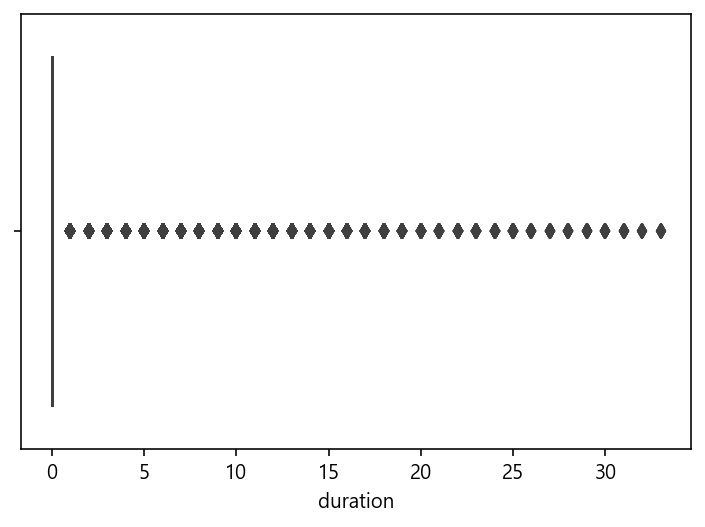

In [53]:
# user_session duration이 1일 이상 되는경우는 이상치에 해당하는데
sns.boxplot(df_user_session['duration'].dt.days);

In [55]:
# 세션 유지길이 분포의 Q1, Q3 확인했으나 둘다 0 (하루 내)로 
# 세션 길이가 1일 이상부터는 이상치로 본다.
Q1 = df_user_session['duration'].dt.days.quantile(0.25)
Q3 = df_user_session['duration'].dt.days.quantile(0.75)
print(Q1,Q3)

0.0 0.0


In [56]:
df_user_session['duration'].describe()

count                     10190988
mean     0 days 00:17:35.490685692
std      0 days 06:32:30.976772153
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:01:03
75%                0 days 00:04:29
max               33 days 14:34:36
Name: duration, dtype: object

- 정상범위 (세션 길이 1일 이내)

In [58]:
# duration 기준 segmentation
cond = df_user_session['duration'].dt.days == 0
a = set(df_user_session[cond].index) # 정상범위
b = set(df_user_session[~cond].index) # 이상치

In [64]:
cond = df_19_oct['event_time'].dt.week > 40
df = df_19_oct[cond]

In [65]:
# 정상범위 총 매출 및 평단가
c1 = df['user_session'].isin(a)
c2 = df['event_type'] == 'purchase'
print(df[c1 & c2]['price'].sum())
print(df[c1 & c2]['price'].sum() / len(df[c1 & c2]['price']))

208084260.0
307.1984599054271


In [66]:
c1 = df['user_session'].isin(a)
c2 = df['event_type'] == 'purchase'
df[c1&c2].value_counts('category_code', normalize=True).head(10)

category_code
electronics.smartphone              0.452999
unknown                             0.238814
electronics.audio.headphone         0.040461
electronics.video.tv                0.028920
electronics.clocks                  0.023738
appliances.kitchen.washer           0.021351
computers.notebook                  0.020172
appliances.environment.vacuum       0.016449
appliances.kitchen.refrigerators    0.015082
electronics.tablet                  0.007466
dtype: float64

In [67]:
c1 = df['user_session'].isin(a)
df[c1].value_counts('category_code', normalize=True).head(10)

category_code
unknown                             0.319605
electronics.smartphone              0.268265
electronics.clocks                  0.030040
electronics.video.tv                0.027220
computers.notebook                  0.026361
electronics.audio.headphone         0.025681
appliances.kitchen.refrigerators    0.020992
appliances.kitchen.washer           0.020399
apparel.shoes                       0.019714
appliances.environment.vacuum       0.018927
dtype: float64

In [68]:
c1 = df['user_session'].isin(a)
df[c1].value_counts('event_type', normalize=True)

event_type
view        0.962390
cart        0.020294
purchase    0.017316
dtype: float64

- 이상치 (세션 길이 1일 이상)

In [69]:
# 이상치 총 매출 및 평단가
c1 = df['user_session'].isin(b)
c2 = df['event_type'] == 'purchase'
print(df[c1 & c2]['price'].sum())
print(df[c1 & c2]['price'].sum() / len(df[c1 & c2]['price']))

136999.56
357.70120757180155


In [70]:
c1 = df['user_session'].isin(b)
df[c1].value_counts('category_code', normalize=True).head(10)

category_code
electronics.smartphone              0.374969
unknown                             0.280265
electronics.clocks                  0.043027
electronics.audio.headphone         0.041121
computers.notebook                  0.032506
appliances.kitchen.washer           0.017950
appliances.kitchen.refrigerators    0.016358
computers.desktop                   0.016230
electronics.video.tv                0.014277
electronics.tablet                  0.009731
dtype: float64

In [71]:
c1 = df['user_session'].isin(b)
c2 = df['event_type'] == 'purchase'
df[c1&c2].value_counts('category_code', normalize=True).head(10)

category_code
electronics.smartphone              0.579634
unknown                             0.130548
computers.notebook                  0.065274
appliances.kitchen.refrigerators    0.060052
appliances.kitchen.washer           0.049608
electronics.video.tv                0.036554
electronics.camera.video            0.013055
appliances.environment.vacuum       0.013055
computers.desktop                   0.007833
electronics.audio.headphone         0.007833
dtype: float64

In [72]:
c1 = df['user_session'].isin(b)
df[c1].value_counts('event_type', normalize=True)

event_type
view        0.990304
cart        0.005243
purchase    0.004453
dtype: float64

In [73]:
# 정상범위 대비 이상치 총매출 비율
print(round((136999.56/208084260) * 100, 3), '%')

0.066 %


- user_session이 가장 긴 경우 탐색
    - 10/1, 2, 15, 18, 21, 22, 23, 11/1, 11/3
    - 똑같은 상품을 계속해서 view만 하는데 어떤 경우? 
    - 첫번째의 경우, product_id, 가격까지 똑같고 
    - 두번째,세번째의 경우, product_id는 같으나 가격의 변동이 조금씩 있다.
    - session이 계속 유지되는 이유는 파악이 필요하다. 

In [74]:
# session 길이가 가장 긴 경우
# 똑같은 제품을 한달 내내 view만 생성
a = df_19_oct[df_19_oct['user_session'] == '83085f41-22c3-4f27-bc29-bfaaf460d902']
a.style.background_gradient(axis=0, gmap=a['price'], cmap='RdYlGn_r', subset=['price'])

In [75]:
# session 길이가 두번째로 긴 경우
# view만 존재 가격변동 발생
b = df_19_oct[df_19_oct['user_session'] == '18e33676-8d30-48e9-9142-d7cb1a4da86e']
b.style.background_gradient(axis=0, gmap=b['price'], cmap='RdYlGn_r', subset=['price'] )

In [76]:
df_19_nov[df_19_nov['user_session'] == '18e33676-8d30-48e9-9142-d7cb1a4da86e']

event_time event_type  product_id  \
2178762  2019-11-02 17:45:25+06:00       view     1004858   
4085058  2019-11-03 21:02:56+06:00       view     1004858   
10121083 2019-11-07 12:39:36+06:00       view     1004858   
14336235 2019-11-09 17:39:57+06:00       view     1004858   
16977495 2019-11-10 23:35:43+06:00       view     1004858   
17270694 2019-11-11 05:48:11+06:00       view     1004858   
20219406 2019-11-12 17:51:30+06:00       view     1004858   
50476311 2019-11-20 22:23:26+06:00       view     1004858   
50825063 2019-11-21 02:59:22+06:00       view     1004858   
52094099 2019-11-21 21:47:10+06:00       view     1004858   
67231239 2019-12-01 00:52:34+06:00       view     1004858   

                   category_code    brand       price    user_id  \
2178762   electronics.smartphone  samsung  127.919998  548253067   
4085058   electronics.smartphone  samsung  127.930000  548253067   
10121083  electronics.smartphone  samsung  131.660004  548253067   
14336235  electronics.smartphone  samsung  127.720001  548253067   
16977495  electronics.smartphone  samsung  127.449997  548253067   
17270694  electronics.smartphone  samsung  127.430000  548253067   
20219406  electronics.smartphone  samsung  127.150002  548253067   
50476311  electronics.smartphone  samsung  126.860001  548253067   
50825063  electronics.smartphone  samsung  126.860001  548253067   
52094099  electronics.smartphone  samsung  126.820000  548253067   
67231239  electronics.smartphone  samsung  124.180000  548253067   

                                  user_session  
2178762   18e33676-8d30-48e9-9142-d7cb1a4da86e  
4085058   18e33676-8d30-48e9-9142-d7cb1a4da86e  
10121083  18e33676-8d30-48e9-9142-d7cb1a4da86e  
14336235  18e33676-8d30-48e9-9142-d7cb1a4da86e  
16977495  18e33676-8d30-48e9-9142-d7cb1a4da86e  
17270694  18e33676-8d30-48e9-9142-d7cb1a4da86e  
20219406  18e33676-8d30-48e9-9142-d7cb1a4da86e  
50476311  18e33676-8d30-48e9-9142-d7cb1a4da86e  
50825063  18e33676-8d30-48e9-9142-d7cb1a4da86e  
52094099  18e33676-8d30-48e9-9142-d7cb1a4da86e  
67231239  18e33676-8d30-48e9-9142-d7cb1a4da86e

In [77]:
# session 길이가 세번째로 긴 경우
# 마찬가지로 view만 존재 가격변동 발생
c = df_19_oct[df_19_oct['user_session'] == '906d839b-760b-4565-a985-f0290f97a818']
c.style.background_gradient(axis=0, gmap=c['price'], cmap='RdYlGn_r', subset=['price'])

-  일별-세션 으로 그룹화
    - 이상치 제거하기보단 일별로 session을 끊어줬더니 이상치가 사라졌다.
    - 데이터 손실 막았다.

In [78]:
day_of_year = df_19_oct['event_time'].dt.dayofyear
df_user_session = df_19_oct.groupby([day_of_year, 'user_session'])['event_time'].agg(['min','max'])
df_user_session['duration'] = df_user_session['max'] - df_user_session['min']
df_user_session.head()

min  \
event_time user_session                                                     
274        00012d23-c857-40af-b8cb-ada787bc00cc 2019-10-01 21:49:07+06:00   
           00016bb9-b50d-4bcb-95d1-9c375f214c66 2019-10-01 15:51:44+06:00   
           0001d713-f9c4-4d96-8f8c-5da2bff7bbf9 2019-10-01 16:09:56+06:00   
           000242ef-7e45-454c-a94c-6c1fd351a974 2019-10-01 18:07:18+06:00   
           0002c5ea-3509-4d0b-9618-7e40925005f0 2019-10-01 12:07:00+06:00   

                                                                      max  \
event_time user_session                                                     
274        00012d23-c857-40af-b8cb-ada787bc00cc 2019-10-01 21:49:51+06:00   
           00016bb9-b50d-4bcb-95d1-9c375f214c66 2019-10-01 15:52:14+06:00   
           0001d713-f9c4-4d96-8f8c-5da2bff7bbf9 2019-10-01 16:18:52+06:00   
           000242ef-7e45-454c-a94c-6c1fd351a974 2019-10-01 18:07:18+06:00   
           0002c5ea-3509-4d0b-9618-7e40925005f0 2019-10-01 12:10:46+06:00   

                                                       duration  
event_time user_session                                          
274        00012d23-c857-40af-b8cb-ada787bc00cc 0 days 00:00:44  
           00016bb9-b50d-4bcb-95d1-9c375f214c66 0 days 00:00:30  
           0001d713-f9c4-4d96-8f8c-5da2bff7bbf9 0 days 00:08:56  
           000242ef-7e45-454c-a94c-6c1fd351a974 0 days 00:00:00  
           0002c5ea-3509-4d0b-9618-7e40925005f0 0 days 00:03:46

In [79]:
df_user_session.tail()

min  \
event_time user_session                                                     
307        ffff31ba-750c-4dc0-8522-2f9c2f401ac9 2019-11-03 23:57:44+06:00   
           ffff4aec-a881-462a-b5c2-c9b0b7604a66 2019-11-03 20:56:18+06:00   
           ffff5bfd-9602-4315-80a8-e18a9af986cd 2019-11-03 08:50:26+06:00   
           fffff237-cd54-46c2-bc94-0fea54d6b0b4 2019-11-03 10:07:55+06:00   
           fffff7e1-9294-4d6c-8482-e1438ba88380 2019-11-03 10:21:13+06:00   

                                                                      max  \
event_time user_session                                                     
307        ffff31ba-750c-4dc0-8522-2f9c2f401ac9 2019-11-03 23:57:44+06:00   
           ffff4aec-a881-462a-b5c2-c9b0b7604a66 2019-11-03 21:13:41+06:00   
           ffff5bfd-9602-4315-80a8-e18a9af986cd 2019-11-03 08:52:07+06:00   
           fffff237-cd54-46c2-bc94-0fea54d6b0b4 2019-11-03 10:15:03+06:00   
           fffff7e1-9294-4d6c-8482-e1438ba88380 2019-11-03 10:25:17+06:00   

                                                       duration  
event_time user_session                                          
307        ffff31ba-750c-4dc0-8522-2f9c2f401ac9 0 days 00:00:00  
           ffff4aec-a881-462a-b5c2-c9b0b7604a66 0 days 00:17:23  
           ffff5bfd-9602-4315-80a8-e18a9af986cd 0 days 00:01:41  
           fffff237-cd54-46c2-bc94-0fea54d6b0b4 0 days 00:07:08  
           fffff7e1-9294-4d6c-8482-e1438ba88380 0 days 00:04:04

In [80]:
(df_user_session['duration'].dt.total_seconds()//60).describe()

count    1.027320e+07
mean     5.309861e+00
std      2.741016e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      1.435000e+03
Name: duration, dtype: float64

In [81]:
a = df_19_oct[df_19_oct['user_session'] == 'c04b7407-6b58-4508-8691-35c44796247e']
cm = sns.light_palette("green", as_cmap=True)
b = a.style.background_gradient(cmap=cm)
b

In [82]:
# session 길이가 가장 긴 경우
a = df_19_oct[df_19_oct['user_session'] == 'f6f56e66-fb30-4a95-9436-608783af860d']
a.style.background_gradient(axis=0, gmap=a['price'], cmap='RdYlGn_r', subset=['price'])

In [83]:
# session 길이가 두번째로 긴 경우
a = df_19_oct[df_19_oct['user_session'] == 'c04b7407-6b58-4508-8691-35c44796247e']
a.style.background_gradient(axis=0, gmap=a['price'], cmap='RdYlGn_r', subset=['price'])

Hit, page view, event추적, 상거래 추적,사용자, 세션, 히트

In [84]:
df_19_oct.columns

Index(['event_time', 'event_type', 'product_id', 'category_code', 'brand',
       'price', 'user_id', 'user_session', '1M_yn'],
      dtype='object')

In [85]:
# event_type order 지정 
# view -> cart -> purchase
from pandas.api.types import CategoricalDtype
df_19_oct['event_type'] = df_19_oct['event_type'].astype(CategoricalDtype(categories=['view','cart','purchase'], ordered=True))

- cart의 통계치가 가장 높게 나오는이유?

In [86]:
df_19_oct.groupby('event_type')['price'].agg(['min','max','mean','median']).sort_index()

min          max        mean      median
event_type                                           
view        0.77  2574.070068  289.842438  162.139999
cart        1.00  2574.040039  335.263214  197.419998
purchase    0.77  2574.070068  308.719513  179.279999

## 컬럼간 확인

### `price` - `event_time` - `event_type`
- cart의 평균 금액이 가장 높은 이유? 

In [87]:
# 40주차 제거
cond = df_19_oct['event_time'].dt.week > 40
df = df_19_oct[cond]

#### 주차별

- 주차별 - event_type 별 평균 price
    1. cart : 월말에 금액이 급격히 높아진다.
    2. purchase : 42주차 count가 peak -> 평균 금액도 급상승 
    3. view : 42주차, 44주차(월말)이 높긴하지만 다른 event type에 비해 상이한편

In [88]:
# 주차별 평균 price
x1 = df['event_time'].dt.week
x2 = df['event_type']
grouped = df.groupby([x1,x2])['price'].agg(['mean','sum']).reset_index()
pv_mean = pd.pivot_table(grouped, index='event_type', 
                    columns='event_time', values='mean')
print('건당 평균 price')
display(pv_mean)

# 주차별 매출
cond = grouped['event_type'] == 'purchase'
grouped_pur = grouped[cond]
pv_sum = pd.pivot_table(grouped_pur, index='event_type', 
                    columns='event_time', values='sum')
print('주차별 매출')
display(pv_sum)

건당 평균 price


event_time          41          42          43          44
event_type                                                
view        283.346069  291.029755  287.620087  291.120972
cart        329.240265  327.420837  328.101440  349.557373
purchase    293.522797  316.304596  308.605377  309.667328

주차별 매출


event_time          41          42          43          44
event_type                                                
purchase    49766788.0  60204784.0  52295960.0  45953704.0

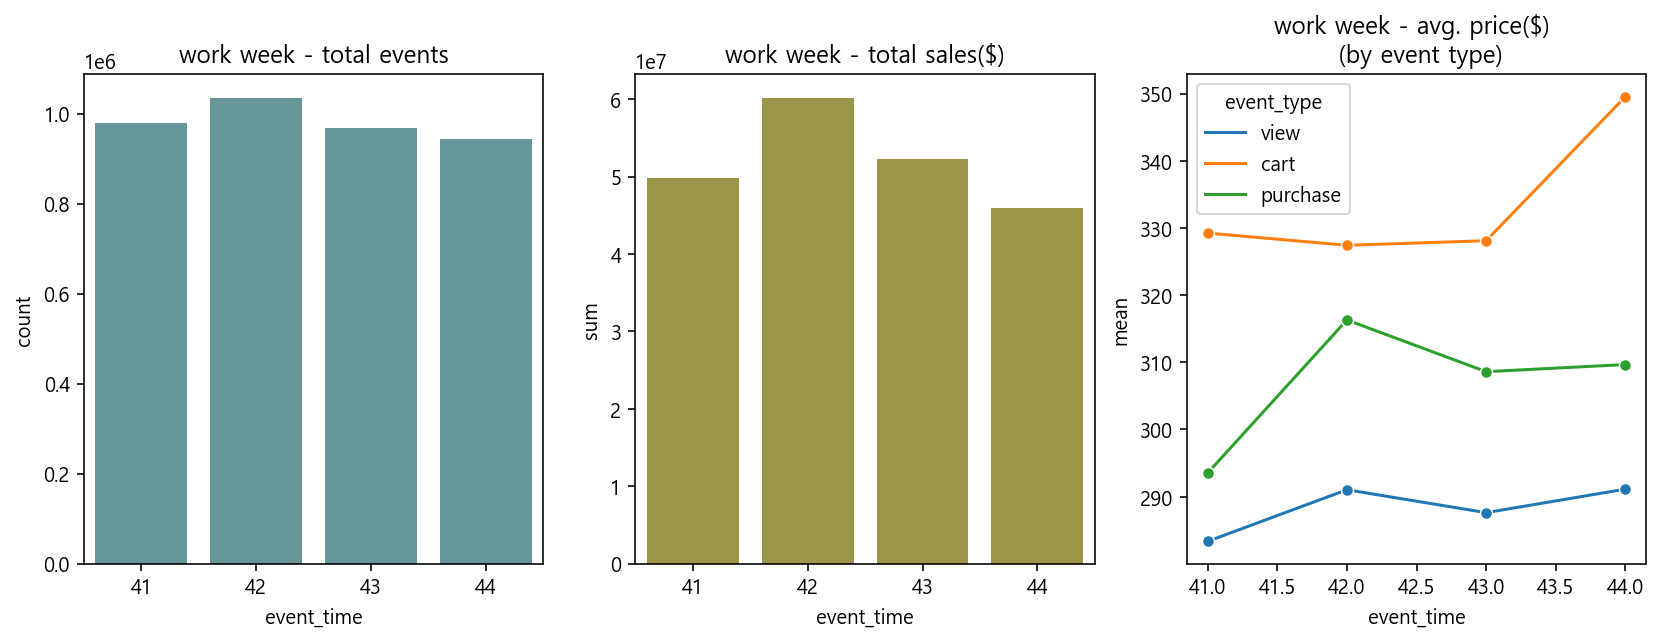

In [89]:
# 그래프
fig, ax = plt.subplots(1,3,figsize=(14,4.5))

color_1 = '#5F9EA0'
color_2 = '#AAA139'

# ax0
x = df_samp['event_time'].dt.week
g = sns.countplot(x = x, color=color_1, ax=ax[0])
g.title.set_text('work week - total events')

# ax1
y = 'sum'
x = 'event_time'
g = sns.barplot(y=y, x=x, data=grouped_pur,
                color=color_2, ax=ax[1])
g.title.set_text('work week - total sales($)')

# ax2
y='mean'
g = sns.lineplot(y=y, x=x, hue='event_type', 
                 data=grouped, marker='o', ax=ax[2])
g.title.set_text('work week - avg. price($) \n (by event type)')

plt.show()

#### 일별

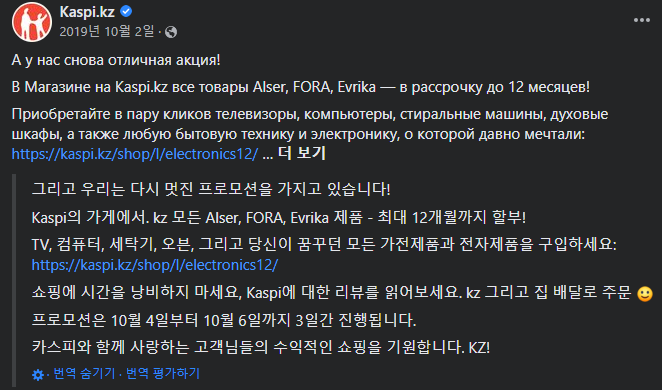

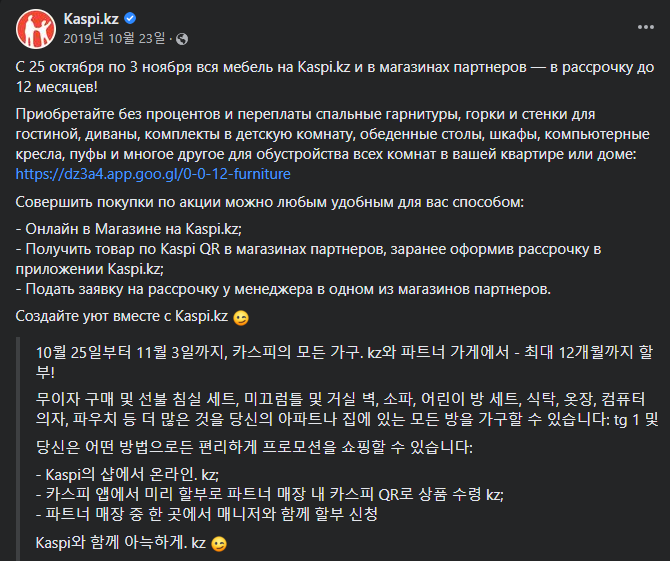

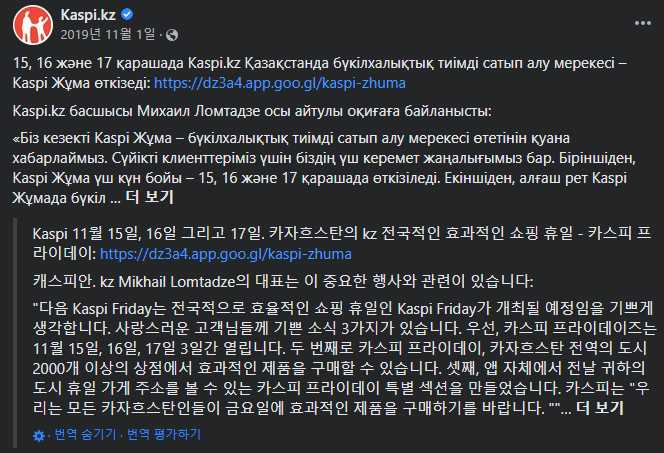

- 일별 평균 price
    1. cart는 월말에 peak
    2. 14일에 event가 진행된 것 같다(추정), 유일하게 구매의 평균금액이 cart평균금액을 뛰어넘었다. 
    3. 특이하게 count는 14일보다 13일이 더 높다. 14일에 이벤트 일어날줄알고 미리 많이 본건가?
    4. 11월 초에 구매가 급격히 떨어졌다.
- 일별 매출
    1.10월 13일과 

In [90]:
# 주차별 평균 price
x1 = df['event_time'].dt.dayofyear
x2 = df['event_type']
grouped = df.groupby([x1,x2])['price'].agg(['mean','sum']).reset_index()
pv_mean = pd.pivot_table(grouped, index='event_type', 
                    columns='event_time', values='mean')
pv_mean

event_time         280         281         282         283         284  \
event_type                                                               
view        295.267883  278.954071  281.956329  289.122498  282.200653   
cart        339.450684  337.676514  343.481445  347.175018  330.699554   
purchase    298.056030  294.118195  302.170288  302.907593  294.739655   

event_time         285         286         287         288         289  ...  \
event_type                                                              ...   
view        282.093292  277.001495  298.016937  294.857941  290.925903  ...   
cart        306.815125  306.803406  329.511993  333.770325  315.815002  ...   
purchase    287.938690  279.790558  331.916718  327.863892  311.730682  ...   

event_time         298         299         300         301         302  \
event_type                                                               
view        288.038177  288.364838  290.834930  289.691711  287.428162   
cart        328.119751  314.190979  323.180145  349.525269  339.665527   
purchase    305.180817  302.474457  306.509552  314.135956  315.245056   

event_time         303         304         305         306         307  
event_type                                                              
view        287.552063  290.180573  293.080353  291.881561  296.228058  
cart        360.327545  364.295319  356.887451  336.335510  342.494385  
purchase    317.258301  321.305939  310.470612  293.650726  297.289948  

[3 rows x 28 columns]

In [91]:
# 주차별 매출
cond = grouped['event_type'] == 'purchase'
grouped_pur = grouped[cond]
pv_sum = pd.pivot_table(grouped_pur, index='event_type', 
                    columns='event_time', values='sum')
pv_sum

event_time        280        281        282        283        284        285  \
event_type                                                                     
purchase    6395686.5  6741483.0  6885554.5  6508272.5  7775232.5  7312779.0   

event_time        286        287        288        289  ...        298  \
event_type                                              ...              
purchase    8147780.5  9544265.0  8564461.0  9805800.0  ...  7319151.5   

event_time        299        300        301        302        303        304  \
event_type                                                                     
purchase    6831688.0  7206652.5  6689839.5  6471666.0  6553605.0  6463390.5   

event_time        305        306        307  
event_type                                   
purchase    6911076.0  6421260.5  6442868.0  

[1 rows x 28 columns]

In [92]:
import datetime as dt
date_labels = [dt.datetime.strptime(f'2019 {x}','%Y %j')
               .strftime('%m-%d') for x in pv_mean.columns]

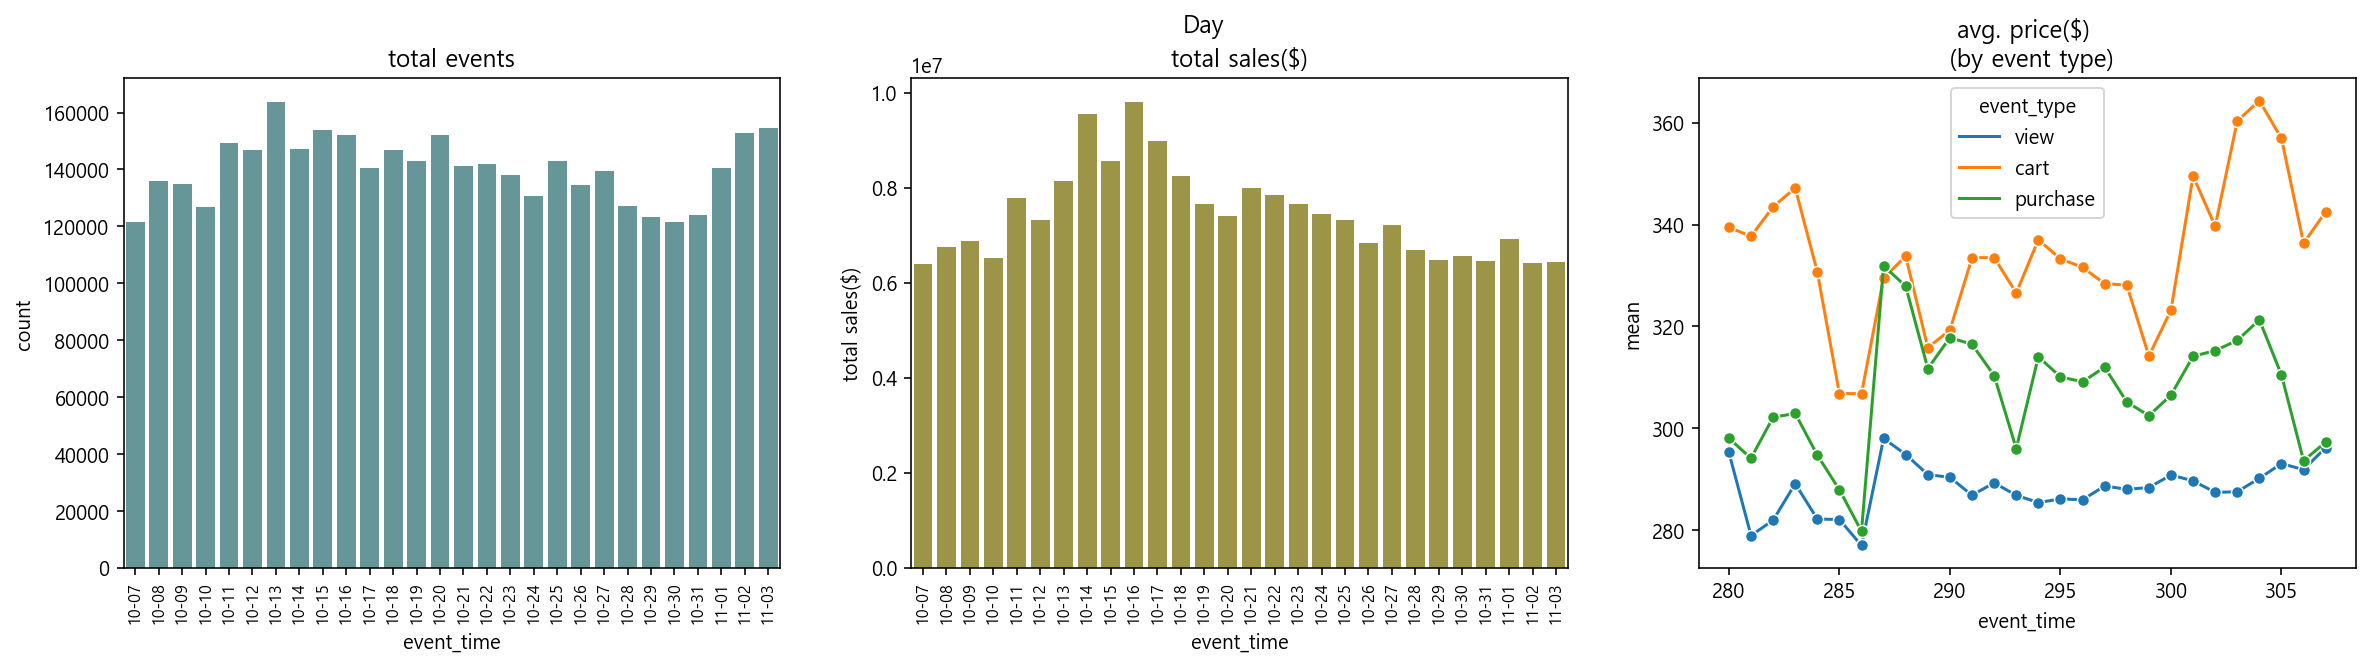

In [94]:
# 그래프
fig, ax = plt.subplots(1,3,figsize=(20,4.5))

# ax0
x = df_samp['event_time'].dt.dayofyear
g = sns.countplot(x = x, color=color_1, ax=ax[0])
g.set_xticklabels(date_labels,fontsize=8, rotation=90)
g.title.set_text('total events')


# ax1
y = 'sum'
x = 'event_time'
g = sns.barplot(y=y, x=x, data=grouped_pur,
                color=color_2, ax=ax[1])
g.set_xticklabels(date_labels,fontsize=8, rotation=90)
g.title.set_text('total sales($)')
ax[1].set(ylabel ='total sales($)')

# ax2
y='mean'
g = sns.lineplot(y=y, x=x, hue='event_type', 
                 data=grouped, marker='o', ax=ax[2])
g.title.set_text('avg. price($) \n (by event type)')
ax[1].set(ylabel ='total sales($)')  # line plot x-tick은 연속데이터그래프라 그런지 label 설정하는 방법이 다른것 같다
# g.set_xticklabels(g.get_xticklabels(),fontsize=8, rotation=90)
fig.suptitle('Day')

plt.show()

- 13일 -> 14일
    - view(87.84%)와 purchase(98.743%)는 낮아지고
    - cart는 급상승 (203.36%)
    - **cart는 늘었는데 구매횟수는 줄었다.**

In [98]:
cond = df['event_time'].dt.dayofyear == 286 # 10월 13일
df[cond].value_counts('event_type')

event_type
view        1585839
purchase      29121
cart          21772
dtype: int64

In [99]:
cond = df_19_oct['event_time'].dt.dayofyear == 287 # 10월 14일
df_19_oct[cond].value_counts('event_type')

event_type
view        1393029
cart          44276
purchase      28755
dtype: int64

#### 요일별

- 요일별 - event_type 별 평균 price
    1. cart의 경우 금요일에 금액이 peak
    2. 나머지는 월요일이나, 목요일이 peak
        - 월요일이나, 목요일이 peak인 이유?

In [100]:
# 평균 price
x1 = df['event_time'].dt.dayofweek
x2 = df['event_type']
grouped = df.groupby([x1,x2])['price'].agg(['mean','sum']).reset_index()
pv_mean = pd.pivot_table(grouped, index='event_type', 
                    columns='event_time', values='mean')
print('평균 price')
display(pv_mean)

# 매출
cond = grouped['event_type'] == 'purchase'
grouped_pur = grouped[cond]
pv_sum = pd.pivot_table(grouped_pur, index='event_type', 
                    columns='event_time', values='sum')
print('매출')
display(pv_sum)

평균 price


event_time           0           1           2           3           4  \
event_type                                                               
view        292.098938  287.044403  286.695923  289.596680  287.466187   
cart        336.392303  335.028046  331.518524  333.604065  335.013977   
purchase    315.825989  312.243683  310.040710  313.665985  306.565125   

event_time           5           6  
event_type                          
view        287.929993  287.498962  
cart        323.307831  324.454742  
purchase    298.582306  294.021667

매출


event_time           0           1           2           3           4  \
event_type                                                               
purchase    30621226.0  29626616.0  30906718.0  29397402.0  30253074.0   

event_time           5           6  
event_type                          
purchase    28216028.0  29200174.0

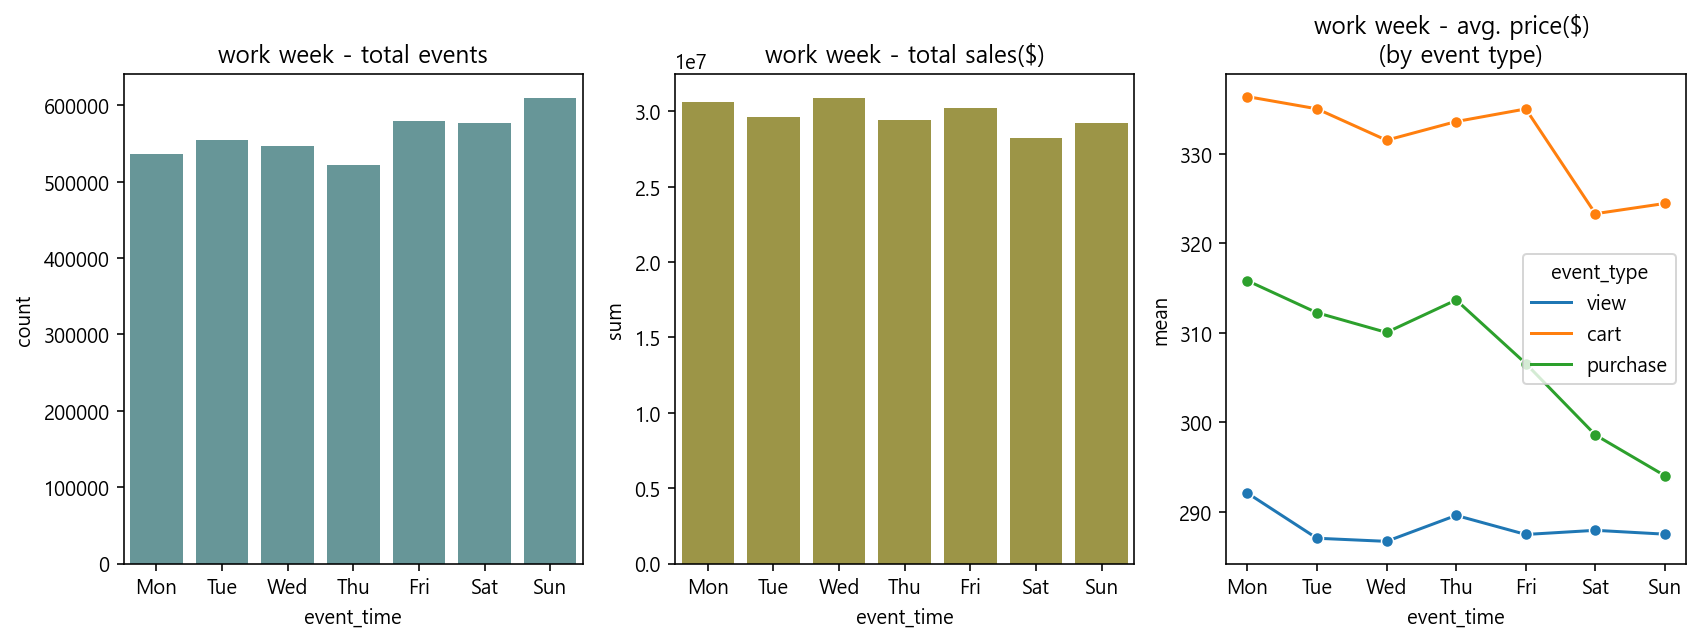

In [101]:
# 그래프
fig, ax = plt.subplots(1,3,figsize=(14,4.5))

color_1 = '#5F9EA0'
color_2 = '#AAA139'

# ax0
x = df_samp['event_time'].dt.dayofweek
g = sns.countplot(x = x, color=color_1, ax=ax[0])
g.title.set_text('work week - total events')
dow_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
g.set_xticklabels(dow_label)

# ax1
y = 'sum'
x = 'event_time'
g = sns.barplot(y=y, x=x, data=grouped_pur,
                color=color_2, ax=ax[1])
g.title.set_text('work week - total sales($)')
dow_label = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
g.set_xticklabels(dow_label)

# ax2
y='mean'
g = sns.lineplot(y=y, x=x, hue='event_type', 
                 data=grouped, marker='o', ax=ax[2])
g.title.set_text('work week - avg. price($) \n (by event type)')
dow_label = ['','Mon','Tue','Wed','Thu','Fri','Sat','Sun']
g.set_xticklabels(dow_label)

plt.show()

#### 시간별

1. 새벽시간대에 event수가 적은데, event별 평균단가는 다른 시간대에 비하여 높다.
2. 19시부터 22시까지 event수는 급상승 하는데, 같은시간대의 매출액은 감소한다.
3. 일과시간의 매출액이 가장 높다.

In [102]:
# 평균 price
x1 = df['event_time'].dt.hour
x2 = df['event_type']
grouped = df.groupby([x1,x2])['price'].agg(['mean','sum']).reset_index()
pv_mean = pd.pivot_table(grouped, index='event_type', 
                    columns='event_time', values='mean')
print('평균 price')
display(pv_mean)

# 매출
cond = grouped['event_type'] == 'purchase'
grouped_pur = grouped[cond]
pv_sum = pd.pivot_table(grouped_pur, index='event_type', 
                    columns='event_time', values='sum')
print('매출')
display(pv_sum)

평균 price


event_time          0           1           2           3           4   \
event_type                                                               
view        295.393280  303.533722  311.325684  321.534729  316.954651   
cart        360.934448  372.632568  395.364929  404.673035  410.319366   
purchase    326.959686  340.993042  356.295105  375.953827  369.869812   

event_time          5           6           7           8           9   ...  \
event_type                                                              ...   
view        308.958160  288.715759  281.466309  277.263397  279.598206  ...   
cart        379.268738  341.488983  316.341980  304.642059  310.790619  ...   
purchase    356.647430  336.062012  283.510590  278.108154  292.066833  ...   

event_time          14          15          16          17          18  \
event_type                                                               
view        285.303986  285.311005  285.430511  287.623322  290.024109   
cart        324.801788  337.976196  329.998566  336.862762  338.942902   
purchase    307.210144  314.549805  312.228149  316.481934  310.455109   

event_time          19          20          21          22          23  
event_type                                                              
view        290.207977  289.011505  287.630737  287.563202  289.328217  
cart        329.748779  325.646973  322.265686  327.766632  336.172577  
purchase    311.600067  303.033997  293.139893  295.955963  300.417358  

[3 rows x 24 columns]

매출


event_time         0          1          2           3           4   \
event_type                                                            
purchase    7289566.0  5227082.5  3249055.0  2168877.75  1323024.25   

event_time           5            6          7          8          9   ...  \
event_type                                                             ...   
purchase    911234.1875  921482.0625  1405362.0  3489701.0  7807822.5  ...   

event_time          14          15          16          17          18  \
event_type                                                               
purchase    15471102.0  15626205.0  14742164.0  13682146.0  11808470.0   

event_time          19          20          21         22         23  
event_type                                                            
purchase    11134094.0  10408005.0  10026850.0  9603475.0  8555285.0  

[1 rows x 24 columns]

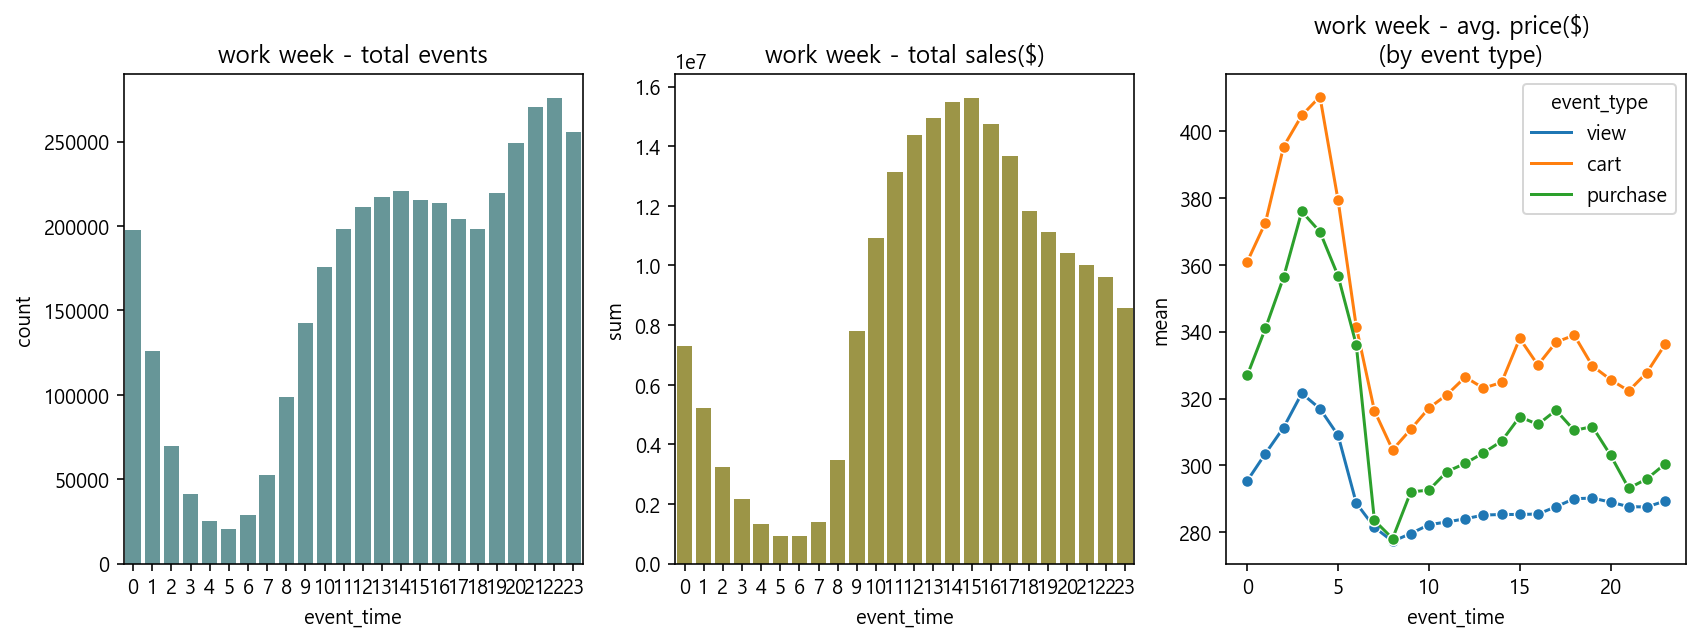

In [110]:
# 그래프
fig, ax = plt.subplots(1,3,figsize=(14,4.5))

color_1 = '#5F9EA0'
color_2 = '#AAA139'

# ax0
x = df_samp['event_time'].dt.hour
g = sns.countplot(x = x, color=color_1, ax=ax[0])
g.title.set_text('work week - total events')

# ax1
y = 'sum'
x = 'event_time'
g = sns.barplot(y=y, x=x, data=grouped_pur,
                color=color_2, ax=ax[1])
g.title.set_text('work week - total sales($)')

# ax2
y='mean'
g = sns.lineplot(y=y, x=x, hue='event_type', 
                 data=grouped, marker='o', ax=ax[2])
g.title.set_text('work week - avg. price($) \n (by event type)')

plt.show()

In [122]:
df[df['event_time'].dt.hour == 4].value_counts('category_code', normalize=True).head(10)

category_code
unknown                        0.315822
electronics.smartphone         0.265486
electronics.clocks             0.042761
electronics.audio.headphone    0.033015
computers.notebook             0.027797
electronics.video.tv           0.022786
apparel.shoes                  0.016937
apparel.shoes.keds             0.014702
computers.desktop              0.013538
auto.accessories.player        0.013098
dtype: float64

In [123]:
df[df['event_time'].dt.hour == 8].value_counts('category_code', normalize=True).head(10)

category_code
unknown                             0.346149
electronics.smartphone              0.244620
electronics.clocks                  0.027411
electronics.video.tv                0.026314
electronics.audio.headphone         0.022608
computers.notebook                  0.022337
apparel.shoes                       0.021631
appliances.kitchen.refrigerators    0.020901
appliances.kitchen.washer           0.020638
appliances.environment.vacuum       0.017495
dtype: float64

In [144]:
week 
pur = df[df['event_type']=='purchase']
pur['dow'] = pur['event_time'].dt.dayofweek
pur['hour'] = pur['event_time'].dt.hour

grouped = pur.groupby(['dow','hour'])['price'].sum()
grouped = grouped.reset_index()

pv = pd.pivot_table(grouped, index='dow', columns='hour', values='price')
pv

hour            0           1             2             3              4   \
dow                                                                         
0     1.103380e+06  861972.000  459746.71875  371627.46875  199433.906250   
1     9.965583e+05  690608.250  458206.65625  281303.25000  158508.093750   
2     1.076451e+06  727430.000  451736.81250  309888.50000  167732.812500   
3     9.871675e+05  761594.000  449984.31250  301517.65625  193149.843750   
4     1.081339e+06  787204.125  467753.68750  326221.75000  218107.609375   
5     1.034177e+06  710397.750  465354.43750  298026.37500  201068.375000   
6     1.010493e+06  687876.375  496272.50000  280292.68750  185023.625000   

hour             5              6              7            8            9   \
dow                                                                           
0     144651.015625  129147.703125  246166.703125  553513.8750  1154157.750   
1      92870.218750  135417.171875  190387.437500  517683.1250  1158985.875   
2     136606.234375  124848.390625  225584.718750  510970.1875  1202878.375   
3     120171.789062  122309.718750  176236.953125  523075.8125  1133493.500   
4     152755.734375  135442.375000  204942.046875  537469.0000  1168918.000   
5     126895.078125  146818.359375  197056.593750  442706.6250  1013143.500   
6     137284.140625  127498.320312  164987.546875  404282.3750   976245.750   

hour  ...          14           15           16           17           18  \
dow   ...                                                                   
0     ...  2225187.50  2291124.750  2228572.750  2051679.500  1783292.125   
1     ...  2290273.00  2335012.750  1973992.000  1814454.000  1597222.500   
2     ...  2181669.25  2424391.500  2197200.750  2013394.500  1883078.125   
3     ...  2250212.75  2188742.500  2080815.125  1946402.625  1576368.000   
4     ...  2222415.75  2186172.250  2028978.875  1968089.250  1663184.000   
5     ...  2123542.25  1896829.875  2038183.375  1868004.875  1574123.750   
6     ...  2177801.75  2303931.500  2194421.500  2020121.750  1731201.500   

hour           19           20           21           22           23  
dow                                                                    
0     1580515.625  1483977.500  1454053.875  1428881.000  1244013.750  
1     1489320.875  1433560.500  1452904.125  1461693.375  1216285.125  
2     1756441.625  1571999.375  1518043.625  1421595.875  1257805.125  
3     1515654.375  1512641.750  1434882.125  1370115.000  1170984.500  
4     1665447.750  1547679.500  1478999.250  1429093.000  1221206.875  
5     1489368.000  1425019.750  1329567.875  1227237.625  1116247.875  
6     1637345.750  1433127.000  1358399.250  1264858.875  1328742.125  

[7 rows x 24 columns]

In [154]:
week_lst = list(set(df['event_time'].dt.week))
week_lst

[41, 42, 43, 44]

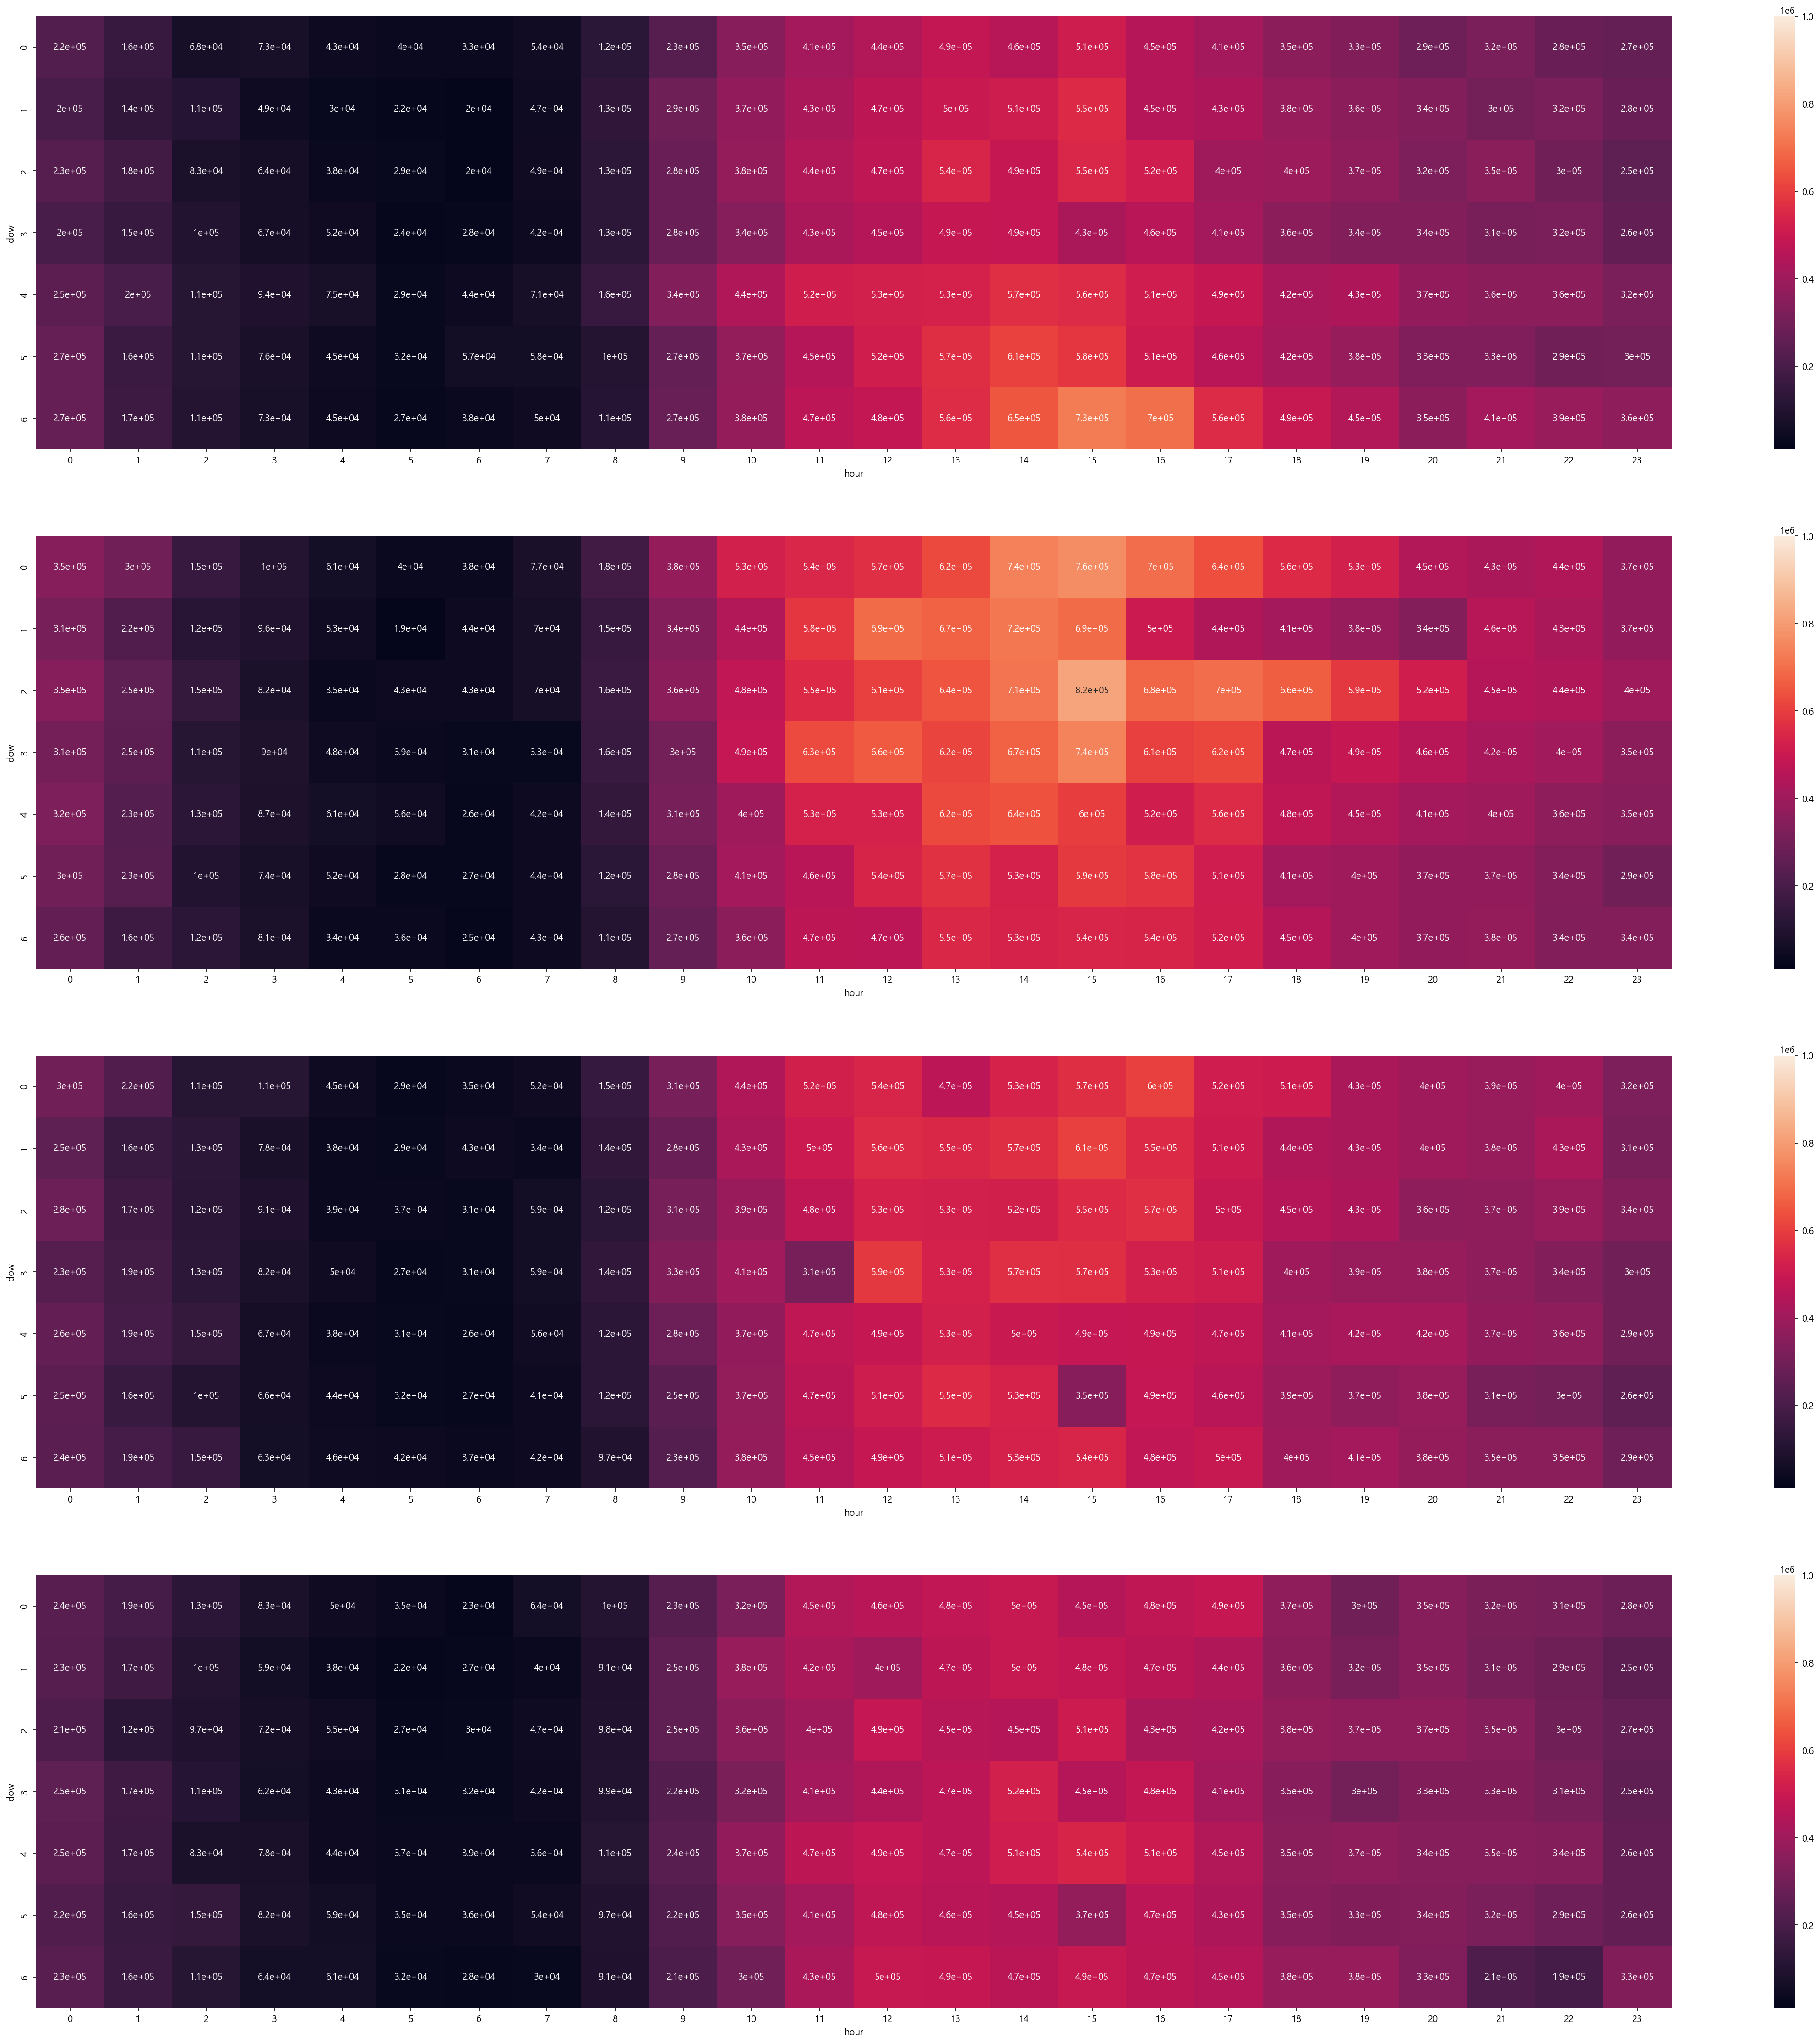

In [173]:
# 주차별 - 요일x시간별 총매출
fig, ax = plt.subplots(4,1, figsize=(40,40))

cond = df['event_type']=='purchase'
pur = df[cond]

pur['week']= pur['event_time'].dt.week
pur['dow'] = pur['event_time'].dt.dayofweek
pur['hour'] = pur['event_time'].dt.hour

for i, w in enumerate(week_lst):
    cond_w = pur['week'] == w
    pur_w = pur[cond_w]

    pv = pd.pivot_table(pur_w, index='dow', columns='hour', values='price', aggfunc='sum')
    
    sns.heatmap(pv, annot=pv, ax=ax[i], vmin=10000, vmax=1000000)
    
    
plt.show()

### `price`-`product_id`

In [182]:
# 구매 데이터 이용
cond = df['event_type'] =='purchase'
pur = df[cond]
pur.head()

event_time event_type  product_id  \
7459415 2019-10-07 00:00:00+06:00   purchase     1004249   
7459416 2019-10-07 00:00:00+06:00   purchase     1005073   
7460251 2019-10-07 00:00:39+06:00   purchase     1801690   
7460252 2019-10-07 00:00:39+06:00   purchase     5301241   
7460317 2019-10-07 00:00:43+06:00   purchase     1004833   

                  category_code    brand        price    user_id  \
7459415  electronics.smartphone    apple   730.260010  541445418   
7459416  electronics.smartphone  samsung  1152.869995  513860677   
7460251    electronics.video.tv  samsung   370.529999  520100233   
7460252                 unknown    vitek    28.240000  535194023   
7460317  electronics.smartphone  samsung   173.929993  540774309   

                                 user_session  1M_yn   cat_code_l  pid_group  
7459415  eae8b127-0020-4603-ad35-6d0785261006   True  electronics          0  
7459416  06c32535-d1b7-40e5-b78e-2aba8a0a5304   True  electronics          0  
7460251  5c3dc6b5-b82d-45f4-a80b-13e8fb9c026b   True  electronics          0  
7460252  45af1a93-dde0-4b8f-8687-21cc874efefe  False      unknown          0  
7460317  d150e189-4254-447d-81c1-71a193c81e2f   True  electronics          0

In [183]:
# product_id 카테고리화
pur['pid_group'] = pur['product_id'] // 10000000
pur.head()

event_time event_type  product_id  \
7459415 2019-10-07 00:00:00+06:00   purchase     1004249   
7459416 2019-10-07 00:00:00+06:00   purchase     1005073   
7460251 2019-10-07 00:00:39+06:00   purchase     1801690   
7460252 2019-10-07 00:00:39+06:00   purchase     5301241   
7460317 2019-10-07 00:00:43+06:00   purchase     1004833   

                  category_code    brand        price    user_id  \
7459415  electronics.smartphone    apple   730.260010  541445418   
7459416  electronics.smartphone  samsung  1152.869995  513860677   
7460251    electronics.video.tv  samsung   370.529999  520100233   
7460252                 unknown    vitek    28.240000  535194023   
7460317  electronics.smartphone  samsung   173.929993  540774309   

                                 user_session  1M_yn   cat_code_l  pid_group  
7459415  eae8b127-0020-4603-ad35-6d0785261006   True  electronics          0  
7459416  06c32535-d1b7-40e5-b78e-2aba8a0a5304   True  electronics          0  
7460251  5c3dc6b5-b82d-45f4-a80b-13e8fb9c026b   True  electronics          0  
7460252  45af1a93-dde0-4b8f-8687-21cc874efefe  False      unknown          0  
7460317  d150e189-4254-447d-81c1-71a193c81e2f   True  electronics          0

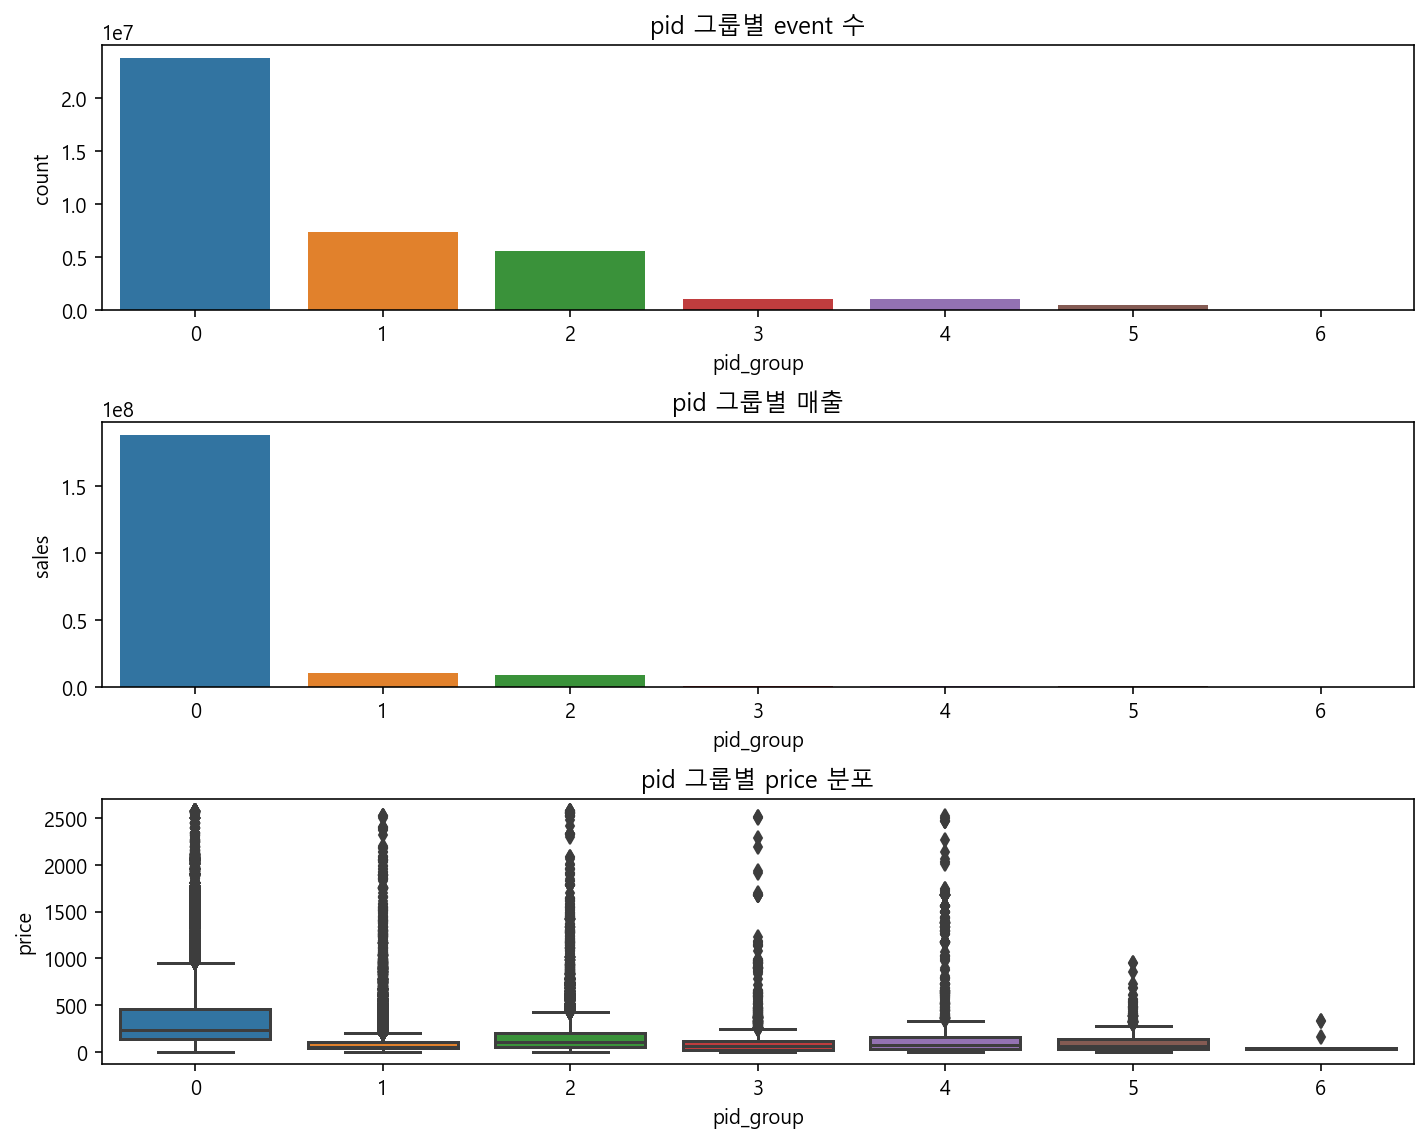

In [281]:
fig, ax = plt.subplots(3,1, figsize=(10,8))

y = 'price'
x = 'pid_group'

#count
sns.countplot(x=x, data=df, ax=ax[0])
ax[0].set_title('pid 그룹별 event 수')

# #총 매출
y='sales'
grouped=pur.groupby('pid_group')['price'].sum().reset_index().rename(columns={'price':'sales'})
sns.barplot(y=y, x=x, data=grouped, ax=ax[1])
ax[1].set_title('pid 그룹별 매출')

# box - price
y='price'
sns.boxplot(y=y, x=x, data=pur, ax=ax[2])
ax[2].set_title('pid 그룹별 price 분포')

plt.tight_layout()
plt.show()

### `price` - `category_code`
- 전자기기, 컴퓨터, 가전의 매출이 전체의 85% 이상이다. 
- 카테고리 다양화 필요하다. 

In [243]:
df['cat_code_l'] = df['category_code'].apply(lambda x:x.split('.')[0])
df.head()

event_time event_type  product_id  \
7459403 2019-10-07 00:00:00+06:00       view     9000688   
7459404 2019-10-07 00:00:00+06:00       view    21408696   
7459405 2019-10-07 00:00:00+06:00       view    28717064   
7459406 2019-10-07 00:00:00+06:00       cart     1307377   
7459407 2019-10-07 00:00:00+06:00       view    22900231   

                    category_code     brand       price    user_id  \
7459403                 kids.toys  gulliver   55.340000  552861743   
7459404        electronics.clocks     casio   52.250000  540034779   
7459405        apparel.shoes.keds   strobbs   51.220001  557457756   
7459406        computers.notebook    lenovo  437.559998  512766859   
7459407  furniture.bedroom.pillow   candide   22.440001  515168282   

                                 user_session  1M_yn   cat_code_l  pid_group  
7459403  174349a3-dd1a-40b0-a926-1f78182b0662  False         kids          0  
7459404  417c7d3d-9a38-46ac-9bf8-d4831d94075e  False  electronics          2  
7459405  267b4ed5-4329-43c9-bac6-49820c3a4b74  False      apparel          2  
7459406  fb25b235-cbb4-4628-8a8a-7f6643eab9a7   True    computers          0  
7459407  d2ad0cb5-7afb-4266-ab8b-c9d55ea115b6  False    furniture          2

In [269]:
grouped = pur.groupby(['pid_group','cat_code_l'])['price'].sum().reset_index(name='sales')
pv = pd.pivot_table(grouped, index='pid_group', columns='cat_code_l', values='sales')
pv

cat_code_l   accessories        apparel    appliances          auto  \
pid_group                                                             
0                    NaN    1350.000000  1.191170e+07  1.005854e+06   
1           15465.860352            NaN  2.537142e+05  1.791110e+03   
2           42501.179688  533416.375000  9.178110e+03  1.008127e+04   
3             898.049988   17559.148438  9.997210e+03           NaN   
4            2212.820068   21068.560547  6.146090e+03  1.415540e+04   
5            3374.209961   36047.769531  2.417491e+04  6.986005e+04   
6                    NaN            NaN           NaN           NaN   

cat_code_l     computers   construction  country_yard   electronics  \
pid_group                                                             
0           9.829768e+06  100106.617188           NaN  1.587465e+08   
1           1.613807e+05  533285.562500           NaN  3.930537e+05   
2           1.654841e+04   33745.519531   5519.959961  5.958654e+05   
3           6.634930e+03  159425.093750   5530.030273           NaN   
4           1.925460e+03   21805.890625           NaN           NaN   
5                    NaN    1487.089966           NaN  5.707300e+02   
6                    NaN     443.359985           NaN           NaN   

cat_code_l     furniture           kids      medicine          sport  \
pid_group                                                              
0           2.293916e+05  367776.062500           NaN            NaN   
1           1.353420e+06  203728.250000           NaN  170529.375000   
2           1.698488e+04            NaN  12105.730469  103706.968750   
3           6.922810e+03    2014.679932           NaN    3092.929932   
4           5.559173e+04   39815.968750           NaN    1188.160034   
5                    NaN            NaN           NaN     304.760010   
6                    NaN            NaN           NaN            NaN   

cat_code_l   stationery       unknown  
pid_group                              
0                   NaN  5.738421e+06  
1           1876.540039  7.142799e+06  
2                   NaN  7.064967e+06  
3                   NaN  4.064383e+05  
4                   NaN  6.154020e+05  
5            323.470001  7.949391e+04  
6                   NaN  8.159700e+02

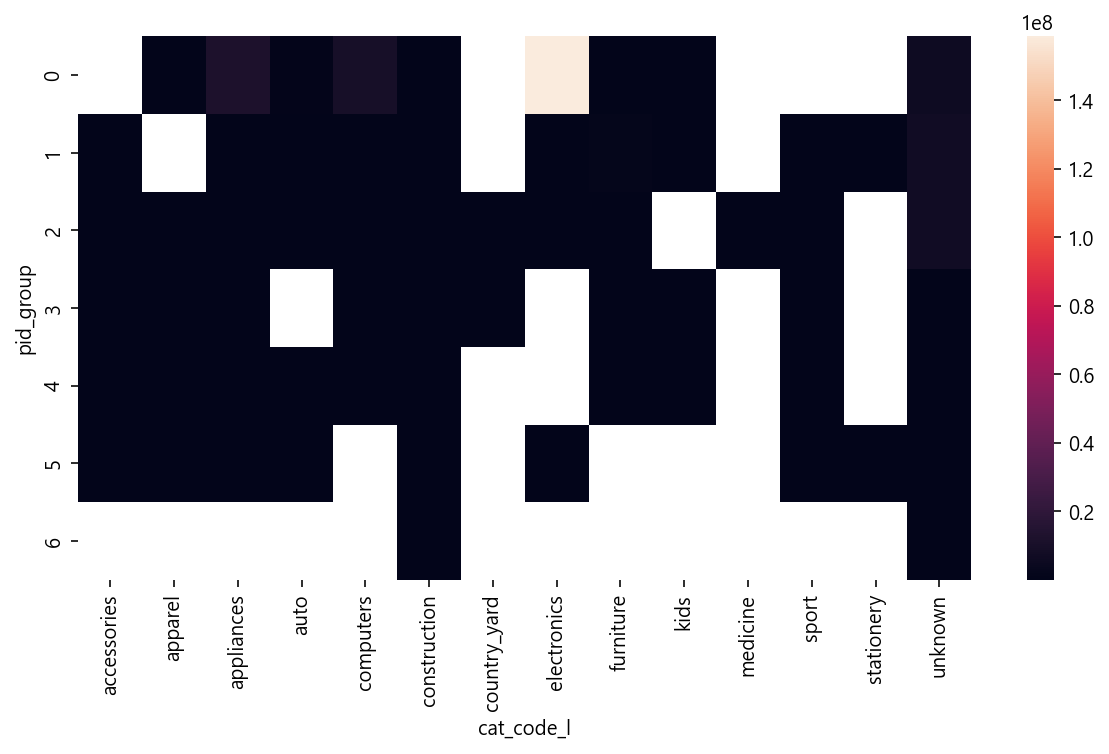

In [270]:
# 전자기기, 컴퓨터, 가전의 매출이 주르르 이룬다. 
# 다른 카테고리의 매출증가가 필요하다.
plt.figure(figsize=(10,5))
sns.heatmap(pv)
plt.show()

In [271]:
grouped = pur.groupby('cat_code_l')['price'].sum()
total_sales = grouped.sum()

(grouped/total_sales *100).sort_values(ascending=False).reset_index(name='prop. (%)')

cat_code_l  prop. (%)
0    electronics  76.714546
1        unknown  10.108641
2     appliances   5.866314
3      computers   4.810392
4      furniture   0.798339
5           auto   0.529121
6   construction   0.408363
7           kids   0.294559
8        apparel   0.292690
9          sport   0.133907
10   accessories   0.030954
11      medicine   0.005814
12  country_yard   0.005307
13    stationery   0.001057

### `price` - `brand`
1. unknown event비율이 높은데(14.46%, 1위) 실제 구매(7.93% 3위)는 상대적으로 떨어진다, 매출은 더 낮다(3.75%, 4위). 
    - unknown brand는 event만 발생시키고, 실제 구매로 이어지지 않는다.
    - 어떤 경우가 unknown인지 정의가 필요하다.
</br></br>
2. apple의 판매건수(19.03%,2위)는 samsung(23.3%, 1위)보다 적은데, 매출액은 samsung의 약 2배다(48.29%, 1위)
3. apple의 판매단가가 독보적으로 높다.

In [376]:
grouped = pur.groupby('brand')['price'].sum().sort_values(ascending=False)
grouped.head(10)


brand
apple      1.005504e+08
samsung    4.223680e+07
xiaomi     8.368729e+06
unknown    7.817846e+06
huawei     4.274815e+06
acer       3.137580e+06
lg         3.003085e+06
lucente    2.852471e+06
sony       2.268749e+06
oppo       2.249202e+06
Name: price, dtype: float32

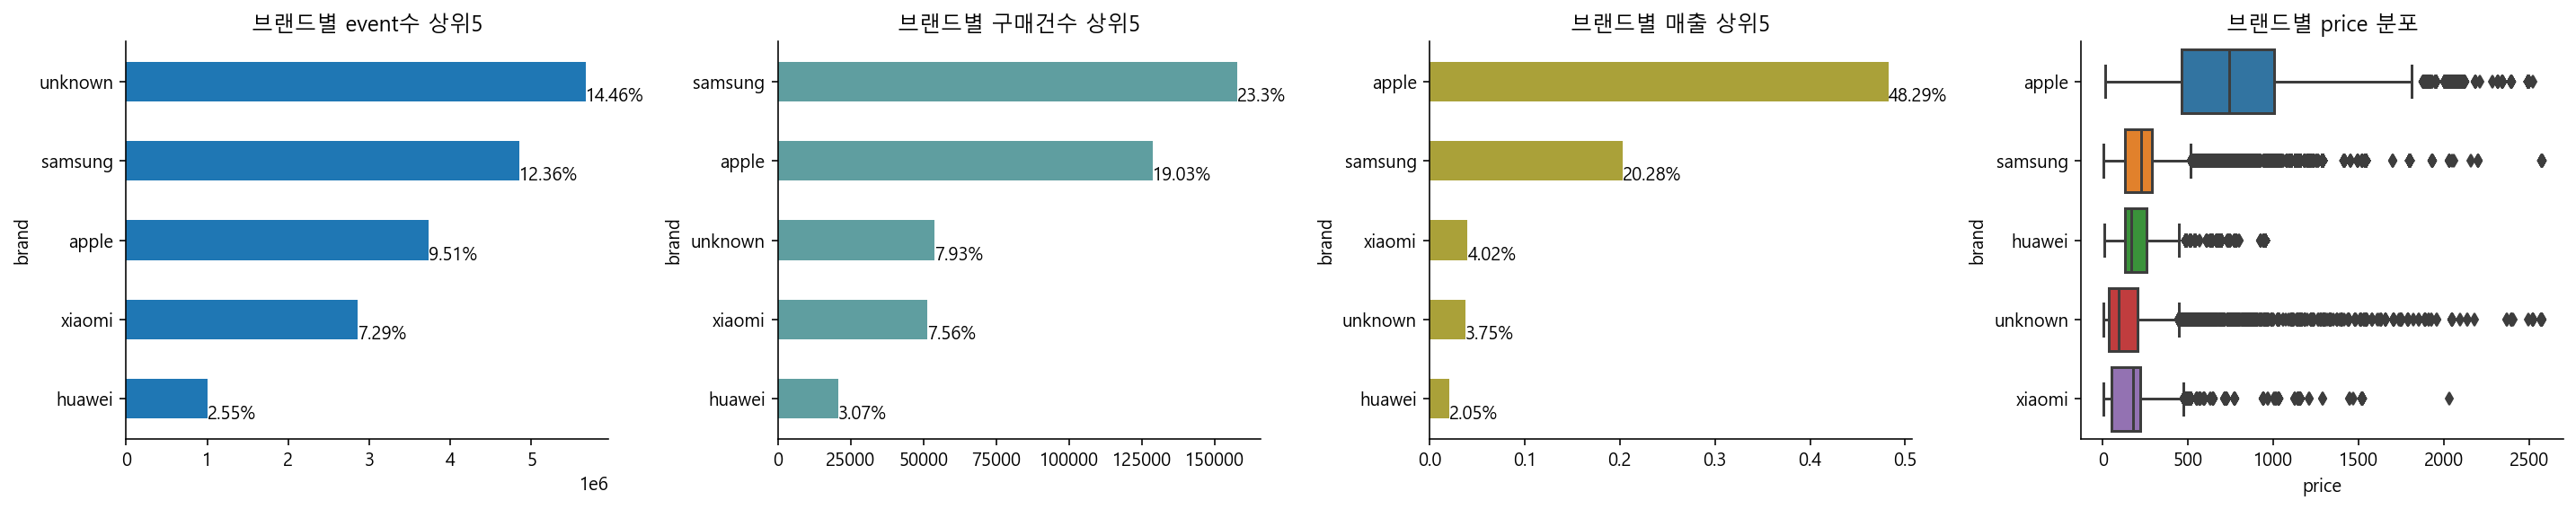

In [374]:
# 그래프
fig, ax = plt.subplots(1,4, figsize=(20,4))

# ax0 - event count
grouped = df.value_counts('brand', sort=True).head().sort_values()
g = grouped.plot(kind='barh',  ax=ax[0])
g.set_title('브랜드별 event수 상위5')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df)*100,2)}%', (val, bar.get_y()))

# ax1 - 구매count
grouped = pur.value_counts('brand', sort=True).head().sort_values()
g = grouped.plot(kind='barh', color = color_1, ax=ax[1])
g.set_title('브랜드별 구매건수 상위5')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(pur)*100,2)}%', (val, bar.get_y()))


# 매출
grouped = pur.groupby('brand')['price'].sum().sort_values(ascending=False)
total_sales = grouped.sum()

grouped = grouped.head(5) / total_sales
grouped = grouped.sort_values()
g = grouped.plot(kind='barh', color = color_2, ax=ax[2])
g.set_title('브랜드별 매출 상위5')

for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val*100,2)}%', (val, bar.get_y()))


# 브랜드별 price 분포 
grouped = pur.groupby('brand')['price'].sum().sort_values(ascending=False).head(5)
sales_top5 = set(grouped.index)
tmp = pur[pur['brand'].isin(sales_top5)]
tmp['brand'] = tmp['brand'].astype('object')

y='brand'
x='price'
g = sns.boxplot(y=y,x=x, data=tmp, ax=ax[3])
g.set_title('브랜드별 price 분포')

sns.despine()
plt.tight_layout()
plt.show()

### `price` - `user_id`
- 이상치(많이 구매하는사람)의 특징은 무엇인가

In [396]:
table = pd.DataFrame(pur.groupby('user_id')['price'].sum().describe()).T
table 

count        mean         std   min         25%         50%  \
price  323621.0  643.356995  2002.03772  0.88  102.940002  241.979996   

             75%           max  
price  584.01001  253101.59375

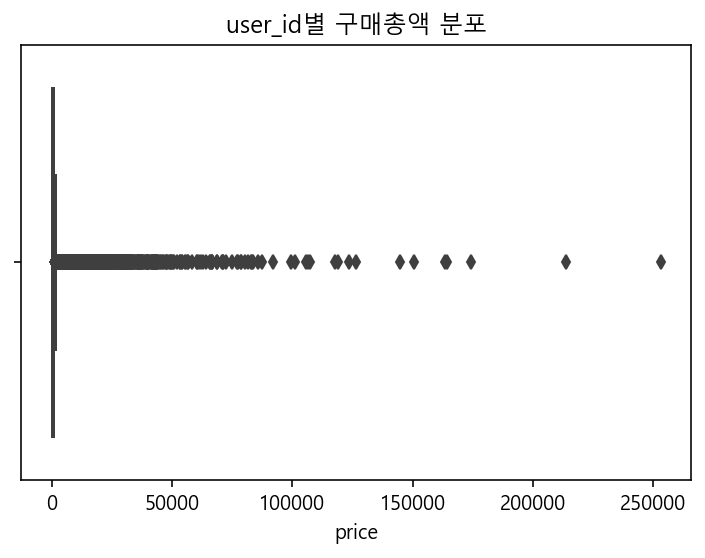

In [472]:
grouped = pur.groupby('user_id')['price'].sum().reset_index()
sns.boxplot(x='price', data=grouped)
plt.title('user_id별 구매총액 분포');

In [406]:
# IQR 설정
Q1 = grouped['price'].quantile(0.25)
Q3 = grouped['price'].quantile(0.75)
IQR = Q3-Q1
print(Q1,Q3,IQR)

102.94000244140625 584.010009765625 481.07000732421875


In [420]:
# 이상치 여부 설정
whis_lower = Q1-1.5*IQR
whis_upper = Q3+1.5*IQR

lower = grouped['price'] >= whis_lower
upper = grouped['price'] <= whis_upper

# 이상치에 해당하는 user_id
outlier = grouped[~lower | ~upper]['user_id'].values

In [423]:
# 컬럼생성
pur['user_outlier_yn'] = np.where(pur['user_id'].isin(outlier), 1, 0)
pur.head()

event_time event_type  product_id  \
7459415 2019-10-07 00:00:00+06:00   purchase     1004249   
7459416 2019-10-07 00:00:00+06:00   purchase     1005073   
7460251 2019-10-07 00:00:39+06:00   purchase     1801690   
7460252 2019-10-07 00:00:39+06:00   purchase     5301241   
7460317 2019-10-07 00:00:43+06:00   purchase     1004833   

                  category_code    brand        price    user_id  \
7459415  electronics.smartphone    apple   730.260010  541445418   
7459416  electronics.smartphone  samsung  1152.869995  513860677   
7460251    electronics.video.tv  samsung   370.529999  520100233   
7460252                 unknown    vitek    28.240000  535194023   
7460317  electronics.smartphone  samsung   173.929993  540774309   

                                 user_session  1M_yn   cat_code_l  pid_group  \
7459415  eae8b127-0020-4603-ad35-6d0785261006   True  electronics          0   
7459416  06c32535-d1b7-40e5-b78e-2aba8a0a5304   True  electronics          0   
7460251  5c3dc6b5-b82d-45f4-a80b-13e8fb9c026b   True  electronics          0   
7460252  45af1a93-dde0-4b8f-8687-21cc874efefe  False      unknown          0   
7460317  d150e189-4254-447d-81c1-71a193c81e2f   True  electronics          0   

         user_outlier_yn  
7459415                0  
7459416                1  
7460251                1  
7460252                0  
7460317                0

- 이상치에 해당하는 user의 경우 apple 구매 건수 및  매출액이 독보적으로 높다.
    - apple 프로모션을 열심히

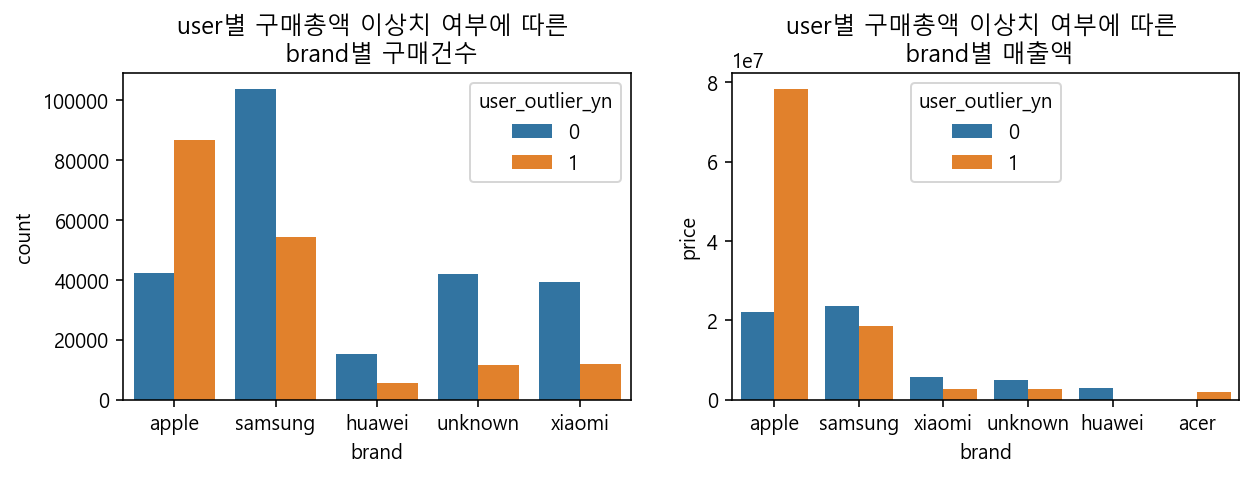

In [443]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

#ax0
grouped = pur.groupby('brand')['price'].sum().sort_values(ascending=False).head(5)
sales_top5 = set(grouped.index)
tmp = pur[pur['brand'].isin(sales_top5)]
tmp['brand'] = tmp['brand'].astype('object')

g=sns.countplot(x='brand', data=tmp, hue='user_outlier_yn', ax=ax[0])
g.set_title('user별 구매총액 이상치 여부에 따른 \n brand별 구매건수')

#ax1
grouped = pur.groupby(['brand','user_outlier_yn'])['price'].sum().sort_values(ascending=False).head(10)
grouped = grouped.reset_index()
grouped['brand'] = grouped['brand'].astype('object')

g = sns.barplot(y='price',x='brand',hue='user_outlier_yn',data=grouped, ax=ax[1])
g.set_title('user별 구매총액 이상치 여부에 따른 \n brand별 매출액')
plt.show()

---

# Summary

## . view -> cart 구매전환율 개선 필요 
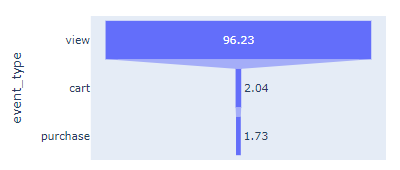

##  electronics를 제외한 카테고리의 경쟁력 확보 필요
- **멀티카테고리 커머스를 지향하지만, 매출이 electronics 제품이 집중되어 있음**
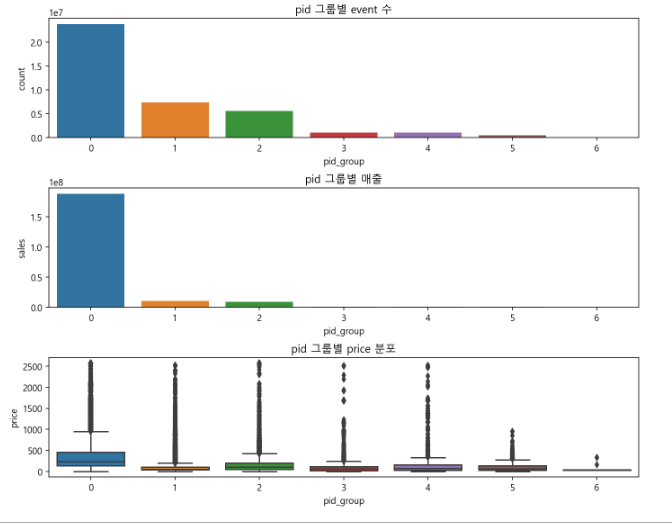
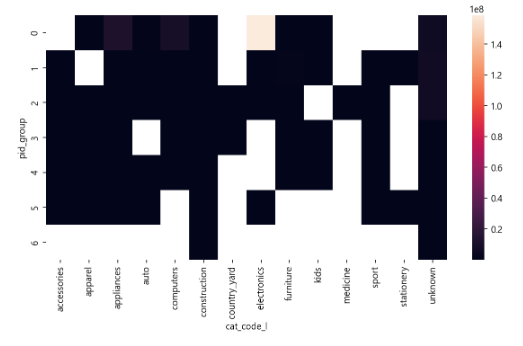

- **특히 apple 상품을 구매하는 특정 user집단에 매출이 집중되어 있음**
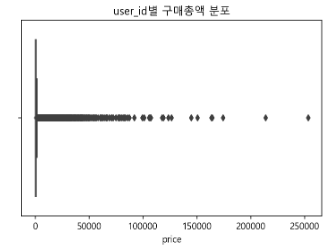
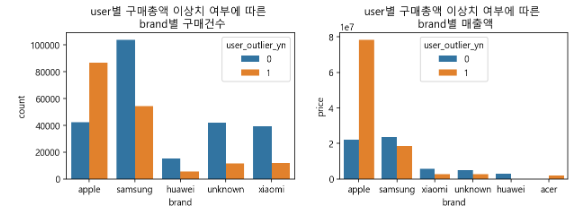

## 구매 event 효과 유효
- **event가 있었던 42주차를 기점으로 평균 구매 금액이 상승 후 유지**
    
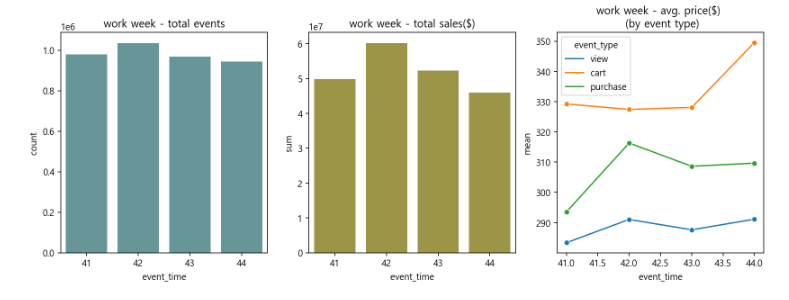
- **하지만 월말의 경우 event수는 증가하지만 구매액은 감소추세**
    - 11월 이후 데이터를 통한 추이 확인 필요

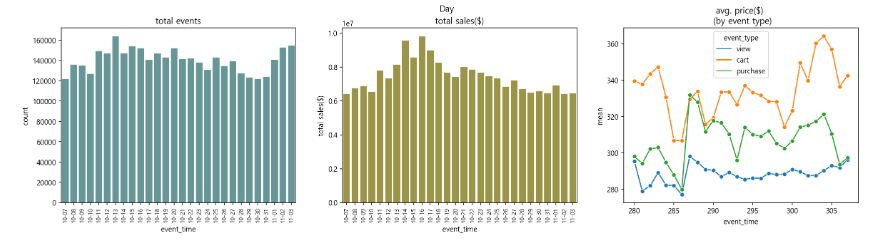

---

# 개선 예정 사항

## 잔여 데이터셋 (2019년 11월 ~2020년 4월) 추가 분석

## 가설검정 적용

## user_session을 활용한 추가 분석

## 코호트 분석
- 특정 기간 특정의 경험을 공유한 집단간 행동패턴을 비교/분석
- 사용자 유지와 이탈 패턴 분석 및 코호트 간 상이한 행동 패턴 분석에 사용
- 월별 그룹으로 분석
    - 기존 설치자 매출은 줄어드는 반면 신규 설치자의 첫 달 매출액은 증가

## AARRR 분석
- Acquisition(획득)
    - 적은 비용으로 다수의 유입을 만드는 것이 좋은 채널
    - KPI : 앱 설치수, DAU, 신규 방문자수, 유입경로 등
    
- Activaation(활성화)
    - WoW 모먼트를 얼만큼 빠르게 보여줄 수 있느냐?
    - 수 많은 A/B test를 통해 
    - KPI : 페이지 뷰, 페이지 체류시간, 이벤트 클릭수, 쿠폰 발행 수, 사이트 내 행동지표 등
    
- Retention(재방문/재구매), 회사의 매출에 큰 영향
    - (참고) 신규 고객의 획득비용은 재구매 고객 획득 비용에 비해 5~25배 의 비용이 든다. (Harvard Business Review)
    - KPI : 재방문율, 재구매율, 구독률 등
    
- Referral(추천/공유)
    - 보통 고객이 서비스에 대해 매우 만족한 직후에 추천이 일어난다. 
    - 적절한 타이밍에 추천/공유를 유도한다.
    - KPI : 추천가입률, 추천 프로그램의 성과
    
- Revenue(매출/수익)
    - KPI : 일 매출, 주간/월간 매출, LTV(Life Time Value) 등
        

(참고)
- LTV(or CLV)
![image](https://user-images.githubusercontent.com/65796882/196660118-d7ff5fb8-3d3a-407d-87c5-4c6bf1c121d6.png)

1. ARPPU(Average Revenue Per Paid User) 객단가
    - 일매출/ Paid user 수 
2. Churn rate(이탈율)
    - SaaS, 구독기반 비즈니스에서 중요한 지표 
    - 이탈의 설정
        - N일간 미 방문, 구독 취소, 재결제 취소, 앱삭제 등
    - 보통 월별비교, 증감분석 한다.

![image](https://user-images.githubusercontent.com/65796882/196664492-46a80ecb-708b-4260-84d5-40be22e79cc6.png)
(출처: https://recurly.com/blog//better-way-to-calculate-your-churn-rate/)

- CAC(Customer Acqusition Cost)
    - CAC < LTV : 올바른 방향 
    - CAC > LTV : 재점검 필

---